In [485]:
# Python 3.9.18
# Numpy : 1.26.0
# Pandas : 2.1.1
# Matplotlib : 3.7.2
# Seaborn : 0.12.2
# Scikit-learn : 1.3.0
# Created: OCT. 25. 2023
# Author: D.W. SHIN
# 2023 전력사용량 예측 AI 경진대회
# 알고리즘 | 정형 | 시계열 | 에너지 | SMAPE
# [Baseline] Random Forest을 기본으로 사용함

import random
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, SGDRegressor, ARDRegression, GammaRegressor, PoissonRegressor, TweedieRegressor, HuberRegressor, QuantileRegressor, RANSACRegressor, ridge_regression, TheilSenRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings(action='ignore') 

## Fixed Random-Seed

In [486]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [487]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
building_df = pd.read_csv('../data/building_info.csv')

In [488]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [489]:
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [490]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08
203999,100_20220824 23,100,20220824 23,20.7,NaN,0.1,95.0,NaN,NaN,540.24


In [491]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


## Train Data Pre-Processing

In [492]:
#결측값을 0으로 채웁니다
train_df = train_df.fillna(0)

In [493]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [494]:
train_df.isnull().sum()

num_date_time    0
건물번호             0
일시               0
기온(C)            0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
dtype: int64

In [495]:
#'일시' 컬럼을 날짜 컬럼으로 추가
DATE_TIME = pd.to_datetime(train_df['일시'])
train_df['YEAR'] = DATE_TIME.dt.year
train_df['MONTH'] = DATE_TIME.dt.month
train_df['DAY'] = DATE_TIME.dt.day
train_df['DATE'] = DATE_TIME.dt.date
train_df['HOUR'] = DATE_TIME.dt.hour
train_df['TIME'] = DATE_TIME.dt.time
train_df['WEEKDAY'] = DATE_TIME.dt.weekday
train_df['DAY_OF_WEEK'] = DATE_TIME.dt.day_of_week

In [496]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
# train_df['month'] = train_df['일시'].apply(lambda x : int(x[4:6]))
# train_df['day'] = train_df['일시'].apply(lambda x : int(x[6:8]))
# train_df['time'] = train_df['일시'].apply(lambda x : int(x[9:11]))

In [497]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,DATE,HOUR,TIME,WEEKDAY,DAY_OF_WEEK
203995,100_20220824 19,100,20220824 19,23.1,0.0,0.9,86.0,0.5,0.0,881.04,2022,8,24,2022-08-24,19,19:00:00,2,2
203996,100_20220824 20,100,20220824 20,22.4,0.0,1.3,86.0,0.0,0.0,798.96,2022,8,24,2022-08-24,20,20:00:00,2,2
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,0.0,0.0,825.12,2022,8,24,2022-08-24,21,21:00:00,2,2
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,0.0,0.0,640.08,2022,8,24,2022-08-24,22,22:00:00,2,2
203999,100_20220824 23,100,20220824 23,20.7,0.0,0.1,95.0,0.0,0.0,540.24,2022,8,24,2022-08-24,23,23:00:00,2,2


In [498]:
# dt.weekday 와 dt.day_of_week는 동일한 것임!!
(train_df['WEEKDAY'] != train_df['DAY_OF_WEEK']).sum()

0

In [499]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [500]:
# 결측치가 '-' 로 채워짐
building_df.isin(['-']).sum()

건물번호             0
건물유형             0
연면적(m2)          0
냉방면적(m2)         0
태양광용량(kW)       64
ESS저장용량(kWh)    95
PCS용량(kW)       95
dtype: int64

In [501]:
building_df.head(20)

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
5,6,건물기타,205754.00,74565.00,-,-,-
6,7,건물기타,101711.52,41341.10,-,800,300
7,8,건물기타,75344.54,24117.00,-,-,-
8,9,건물기타,222882.35,15651.18,-,-,-
9,10,건물기타,31062.00,18637.00,-,-,-


In [502]:
building_df[building_df.isin(['-'])]

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,NaN,NaN,NaN,NaN,-,-,-
1,NaN,NaN,NaN,NaN,-,-,-
2,NaN,NaN,NaN,NaN,NaN,-,-
3,NaN,NaN,NaN,NaN,NaN,-,-
4,NaN,NaN,NaN,NaN,-,NaN,NaN
...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,-,-,-
96,NaN,NaN,NaN,NaN,-,-,-
97,NaN,NaN,NaN,NaN,-,-,-
98,NaN,NaN,NaN,NaN,-,-,-


In [503]:
building_df.replace('-', 'A')

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,A,A,A
1,2,건물기타,122233.47,99000.00,A,A,A
2,3,건물기타,171243.00,113950.00,40,A,A
3,4,건물기타,74312.98,34419.62,60,A,A
4,5,건물기타,205884.00,150000.00,A,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,A,A,A
96,97,호텔및리조트,55144.67,25880.00,A,A,A
97,98,호텔및리조트,53578.62,17373.75,A,A,A
98,99,호텔및리조트,53499.00,40636.00,A,A,A


In [504]:
# 결측치 '-'를 0으로 채움
building_df.replace('-', 0, inplace=True)

In [505]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    object 
 5   ESS저장용량(kWh)  100 non-null    object 
 6   PCS용량(kW)     100 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


In [506]:
# 아래 컬럼의 속성을 float로 변환
building_df['태양광용량(kW)'] = building_df['태양광용량(kW)'].astype(float)
building_df['ESS저장용량(kWh)'] = building_df['ESS저장용량(kWh)'].astype(float)
building_df['PCS용량(kW)'] = building_df['PCS용량(kW)'].astype(float)

In [507]:
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   건물번호          100 non-null    int64  
 1   건물유형          100 non-null    object 
 2   연면적(m2)       100 non-null    float64
 3   냉방면적(m2)      100 non-null    float64
 4   태양광용량(kW)     100 non-null    float64
 5   ESS저장용량(kWh)  100 non-null    float64
 6   PCS용량(kW)     100 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ KB


In [508]:
# building_df을 train_df으로 데이터 프레임 합치기
train_df = pd.merge(train_df, building_df, how='left',on='건물번호')

In [509]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
 10  YEAR           204000 non-null  int32  
 11  MONTH          204000 non-null  int32  
 12  DAY            204000 non-null  int32  
 13  DATE           204000 non-null  object 
 14  HOUR           204000 non-null  int32  
 15  TIME           204000 non-null  object 
 16  WEEKDAY        204000 non-null  int32  
 17  DAY_OF_WEEK    204000 non-nul

In [510]:
train_df.tail()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,HOUR,TIME,WEEKDAY,DAY_OF_WEEK,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
203995,100_20220824 19,100,20220824 19,23.1,0.0,0.9,86.0,0.5,0.0,881.04,...,19,19:00:00,2,2,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203996,100_20220824 20,100,20220824 20,22.4,0.0,1.3,86.0,0.0,0.0,798.96,...,20,20:00:00,2,2,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,0.0,0.0,825.12,...,21,21:00:00,2,2,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,0.0,0.0,640.08,...,22,22:00:00,2,2,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0
203999,100_20220824 23,100,20220824 23,20.7,0.0,0.1,95.0,0.0,0.0,540.24,...,23,23:00:00,2,2,호텔및리조트,57497.84,40035.23,0.0,0.0,0.0


In [511]:
# 생성된 컬럼 중 불필요 컬럼 삭제
train_df.drop(['num_date_time', '일시', 'DATE', 'TIME', 'DAY_OF_WEEK'], axis=1, inplace=True)

In [512]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   건물번호          204000 non-null  int64  
 1   기온(C)         204000 non-null  float64
 2   강수량(mm)       204000 non-null  float64
 3   풍속(m/s)       204000 non-null  float64
 4   습도(%)         204000 non-null  float64
 5   일조(hr)        204000 non-null  float64
 6   일사(MJ/m2)     204000 non-null  float64
 7   전력소비량(kWh)    204000 non-null  float64
 8   YEAR          204000 non-null  int32  
 9   MONTH         204000 non-null  int32  
 10  DAY           204000 non-null  int32  
 11  HOUR          204000 non-null  int32  
 12  WEEKDAY       204000 non-null  int32  
 13  건물유형          204000 non-null  object 
 14  연면적(m2)       204000 non-null  float64
 15  냉방면적(m2)      204000 non-null  float64
 16  태양광용량(kW)     204000 non-null  float64
 17  ESS저장용량(kWh)  204000 non-null  float64
 18  PCS용

In [513]:
pd.unique(train_df['건물유형'])

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

In [514]:
# 레이블링 작업
le = LabelEncoder()
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])

In [515]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   건물번호          204000 non-null  int64  
 1   기온(C)         204000 non-null  float64
 2   강수량(mm)       204000 non-null  float64
 3   풍속(m/s)       204000 non-null  float64
 4   습도(%)         204000 non-null  float64
 5   일조(hr)        204000 non-null  float64
 6   일사(MJ/m2)     204000 non-null  float64
 7   전력소비량(kWh)    204000 non-null  float64
 8   YEAR          204000 non-null  int32  
 9   MONTH         204000 non-null  int32  
 10  DAY           204000 non-null  int32  
 11  HOUR          204000 non-null  int32  
 12  WEEKDAY       204000 non-null  int32  
 13  건물유형          204000 non-null  int32  
 14  연면적(m2)       204000 non-null  float64
 15  냉방면적(m2)      204000 non-null  float64
 16  태양광용량(kW)     204000 non-null  float64
 17  ESS저장용량(kWh)  204000 non-null  float64
 18  PCS용

In [516]:
train_df.corr()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),YEAR,MONTH,DAY,HOUR,WEEKDAY,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
건물번호,1.000000e+00,-0.004505,-0.004135,0.021413,0.022798,0.017324,-0.009030,-0.180474,NaN,-2.790756e-14,3.608018e-15,-3.480358e-15,-1.518670e-14,9.950194e-01,-1.153222e-01,-1.161989e-01,-4.556644e-02,-1.246762e-01,-1.722903e-01
기온(C),-4.504794e-03,1.000000,-0.068643,0.220072,-0.389585,0.419242,0.463308,0.171190,NaN,4.271998e-01,6.949836e-02,2.914288e-01,4.288145e-02,-8.256383e-04,-3.338348e-03,-3.055486e-03,6.433531e-03,1.105861e-02,8.055456e-03
강수량(mm),-4.134622e-03,-0.068643,1.000000,0.048103,0.199491,-0.100483,-0.099372,0.015083,NaN,4.343621e-02,2.710738e-02,1.372893e-02,-5.596441e-02,-2.370964e-03,-2.632912e-03,-2.753116e-03,5.574572e-03,4.214705e-03,5.436438e-03
풍속(m/s),2.141270e-02,0.220072,0.048103,1.000000,-0.218568,0.167946,0.225497,0.109956,NaN,-8.638854e-02,1.002829e-01,1.770734e-01,-1.066293e-01,2.800570e-02,-5.499032e-02,-5.376845e-02,-5.030717e-02,-3.659568e-03,-1.257501e-02
습도(%),2.279767e-02,-0.389585,0.199491,-0.218568,1.000000,-0.571982,-0.560771,-0.129373,NaN,2.537476e-01,1.184344e-01,-2.803901e-01,-1.339402e-02,1.867216e-02,-2.007649e-02,-2.047581e-02,-7.470715e-04,-4.688005e-02,-4.912406e-02
일조(hr),1.732413e-02,0.419242,-0.100483,0.167946,-0.571982,1.000000,0.764701,0.094748,NaN,-4.952327e-02,-7.541481e-02,1.597529e-01,3.987859e-02,1.382064e-02,3.834039e-03,4.099886e-03,-1.532711e-02,-8.744071e-03,-9.407145e-03
일사(MJ/m2),-9.029883e-03,0.463308,-0.099372,0.225497,-0.560771,0.764701,1.000000,0.177750,NaN,-3.801214e-02,-5.684107e-02,1.529886e-01,1.930318e-02,-6.498707e-03,-6.575582e-02,-6.482553e-02,-1.983026e-02,1.128895e-02,1.091857e-02
전력소비량(kWh),-1.804737e-01,0.171190,0.015083,0.109956,-0.129373,0.094748,0.177750,1.000000,NaN,5.584234e-02,9.233027e-03,9.959427e-02,-4.359977e-02,-1.743779e-01,1.346303e-02,1.644439e-02,5.203917e-02,-3.185621e-02,-3.388190e-02
YEAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH,-2.790756e-14,0.427200,0.043436,-0.086389,0.253748,-0.049523,-0.038012,0.055842,NaN,1.000000e+00,-1.333186e-01,-8.672975e-17,-3.773670e-02,-2.770799e-14,5.220941e-15,5.223730e-15,3.273456e-15,6.512695e-15,8.584910e-15


## 모델 선정하기

In [517]:
x_train = train_df.drop(['전력소비량(kWh)'], axis=1)
y_train = train_df['전력소비량(kWh)']

In [518]:
# 성능 지표, 교차 검증 세트
# neg_mean_absolute_error, neg_mean_squared_error, neg_root_mean_squared_error
score_param = 'neg_root_mean_squared_error'
cv_param = 5
round_param = 4

model = LinearRegression(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28929.8391  -4831.997   -1259.1557  -1596.4866   -987.6922]
평균 검증 정확도: -7521.0341


In [519]:
model = SGDRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-3.15591944e+19 -5.98816973e+20 -3.49726906e+20 -5.50909206e+20
 -5.24672690e+18]
평균 검증 정확도: -3.072518011956461e+20


In [520]:
model = ARDRegression()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-28988.8927  -4832.357   -1254.1464  -1559.455    -943.961 ]
평균 검증 정확도: -7515.7624


In [521]:
model = RandomForestRegressor(n_jobs=-1)

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1655.5751 -4386.1361 -1672.3887 -4027.0856 -2223.4045]
평균 검증 정확도: -2792.918


In [522]:
model = GradientBoostingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1860.9075 -4567.3315 -1444.6429 -3574.8755 -1158.5126]
평균 검증 정확도: -2521.254


In [523]:
model = BaggingRegressor()

scores = cross_val_score(model, x_train, y_train, cv=cv_param, scoring=score_param)
print('교차 검증별 정확도:',np.round(scores, round_param))
print('평균 검증 정확도:', np.round(np.mean(scores), round_param))

교차 검증별 정확도: [-1704.0068 -4436.133  -1659.5712 -3916.259  -2213.7029]
평균 검증 정확도: -2785.9346


### 모델별 성능 확인을 위한 함수

In [524]:
x_train, x_test, y_train, y_test = train_test_split(train_df.drop(['전력소비량(kWh)'], axis=1), train_df['전력소비량(kWh)'], test_size=0.2, random_state=123)

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10
    
    length = len(df)
    
    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])
    
    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')
        
    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)
    
    plt.show()

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

## LinearRegression

In [526]:
model = LinearRegression(n_jobs=-1)
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.coef_)
print(model.intercept_)

[-5.47446022e+01  4.11869437e+01  2.87356815e+01  8.63110817e+01
 -9.42742666e+00 -7.59450660e+02  5.05291606e+02  2.27373675e-13
  1.46024051e+02  4.33152860e+00  1.56073000e+01 -4.97598209e+01
  3.07833419e+02 -2.40460646e-03  2.84783988e-03  1.45572278e+00
  7.48237043e-01 -3.47185841e+00]
1946.6135206915544


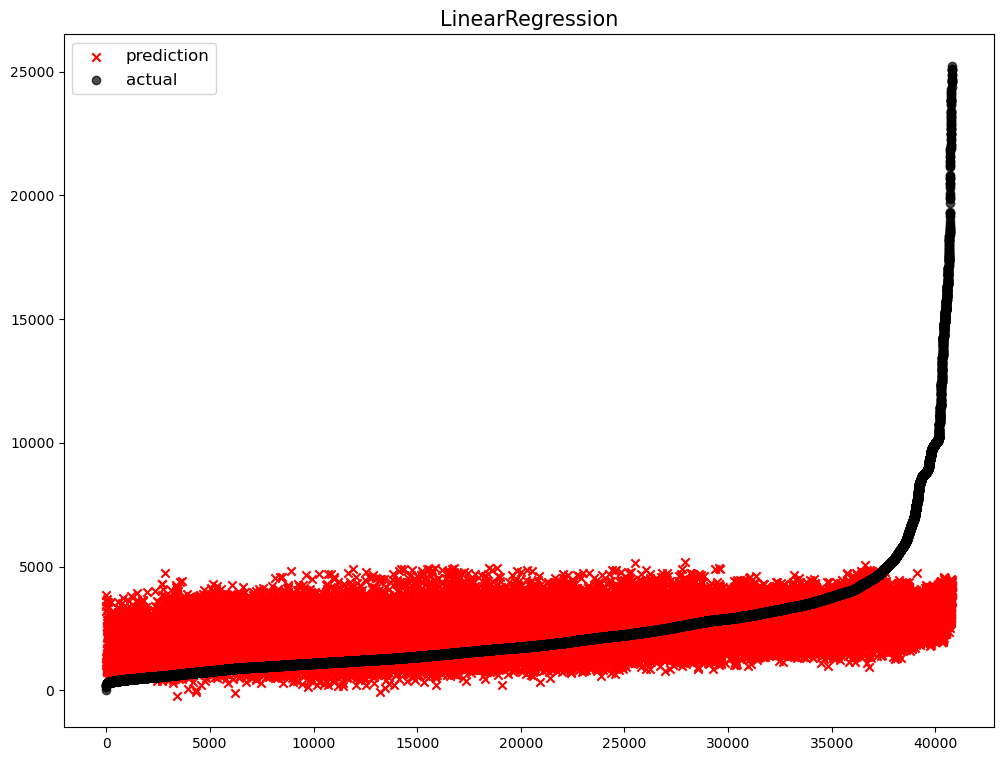

              model           mse
0  LinearRegression  5.297123e+06


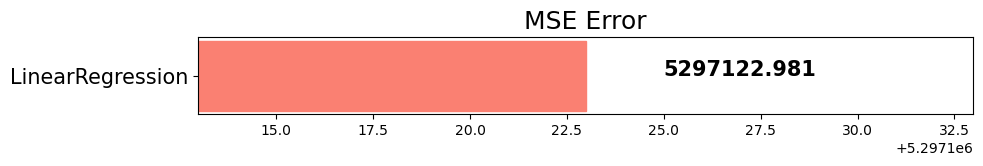

In [527]:
mse_eval('LinearRegression', pred, y_test)

In [528]:
# 값이 커질 수록 큰 규제입니다.
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

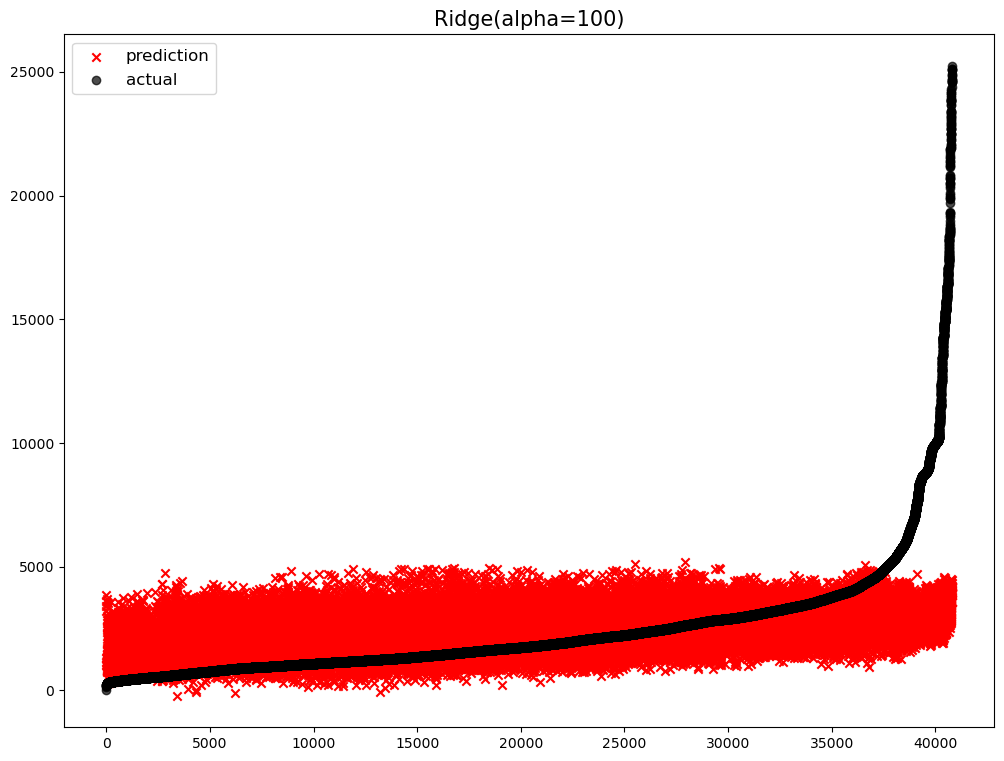

              model           mse
0  Ridge(alpha=100)  5.297131e+06
1  LinearRegression  5.297123e+06


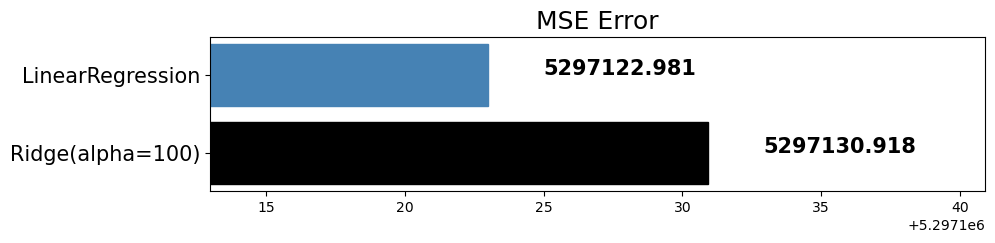

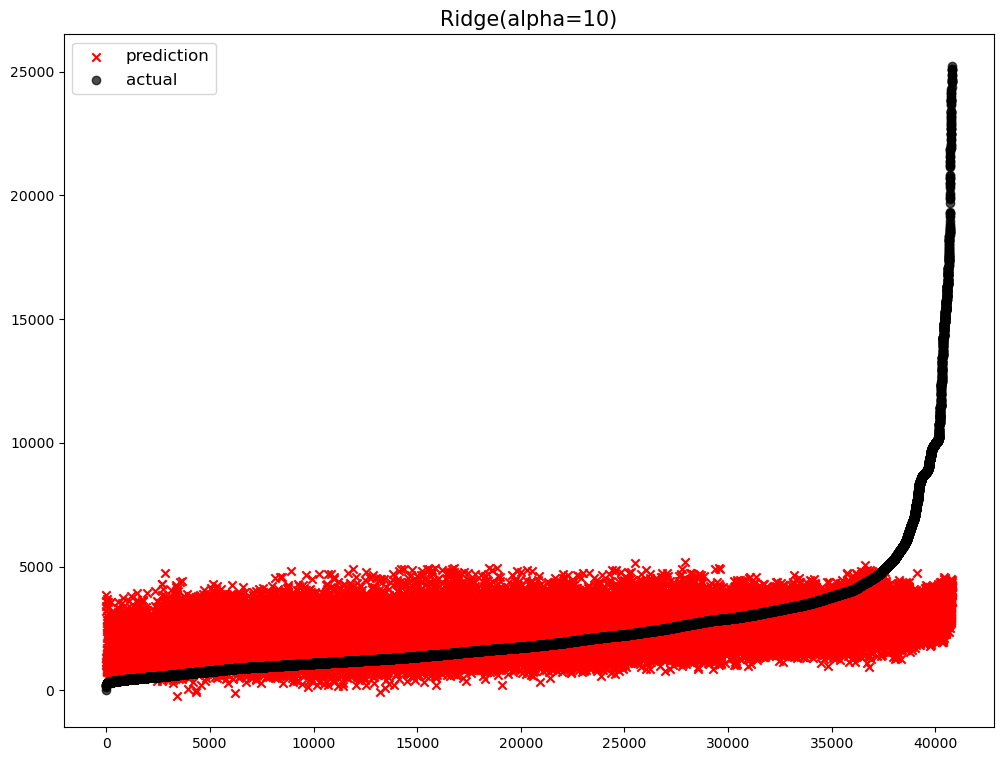

              model           mse
0  Ridge(alpha=100)  5.297131e+06
1   Ridge(alpha=10)  5.297123e+06
2  LinearRegression  5.297123e+06


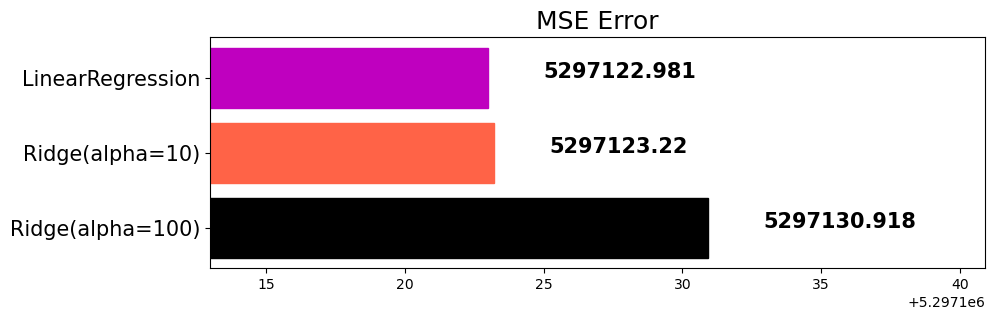

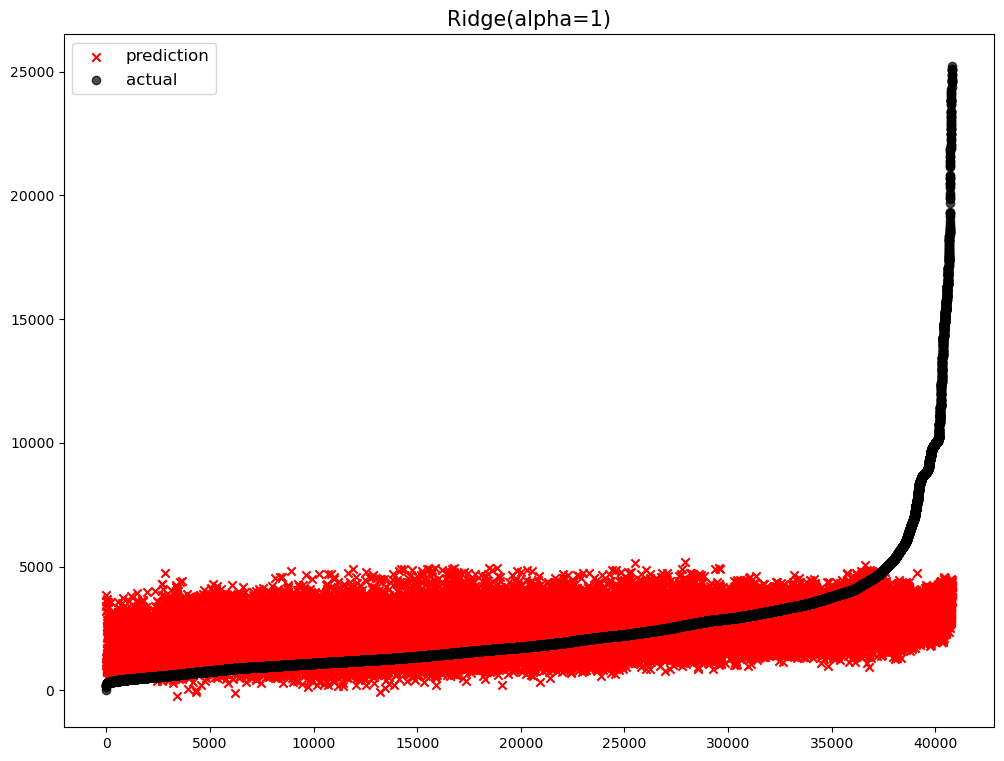

              model           mse
0  Ridge(alpha=100)  5.297131e+06
1   Ridge(alpha=10)  5.297123e+06
2    Ridge(alpha=1)  5.297123e+06
3  LinearRegression  5.297123e+06


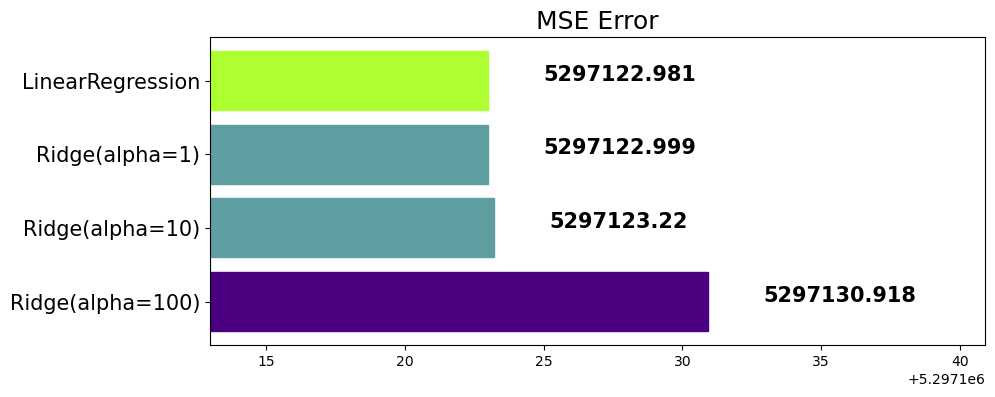

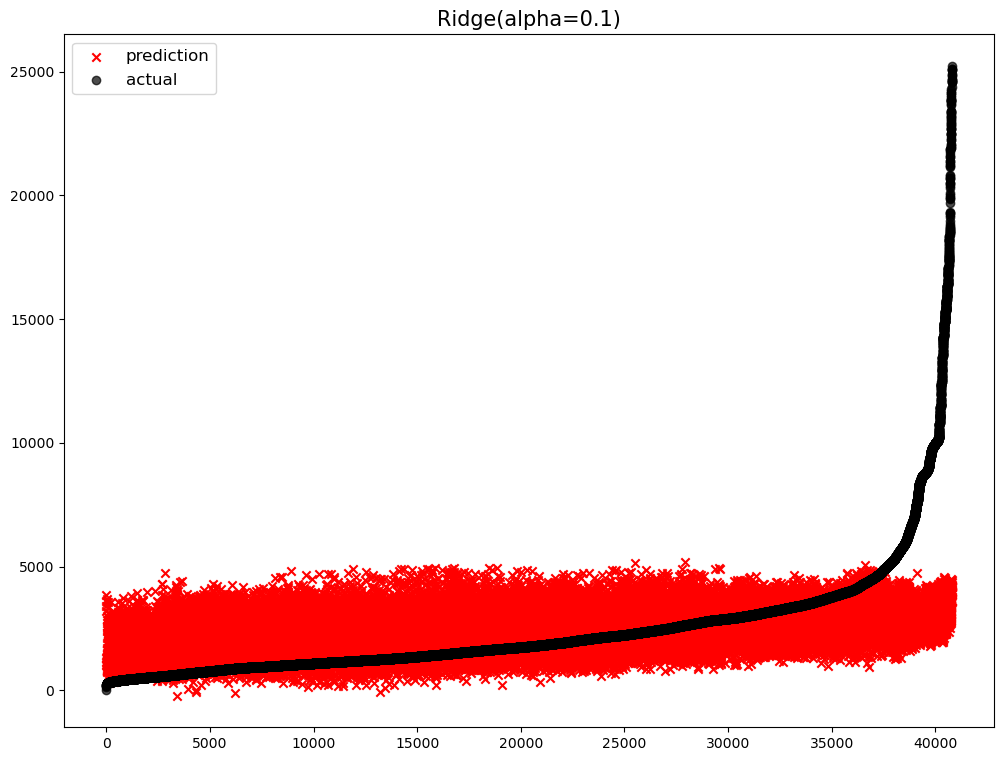

              model           mse
0  Ridge(alpha=100)  5.297131e+06
1   Ridge(alpha=10)  5.297123e+06
2    Ridge(alpha=1)  5.297123e+06
3  Ridge(alpha=0.1)  5.297123e+06
4  LinearRegression  5.297123e+06


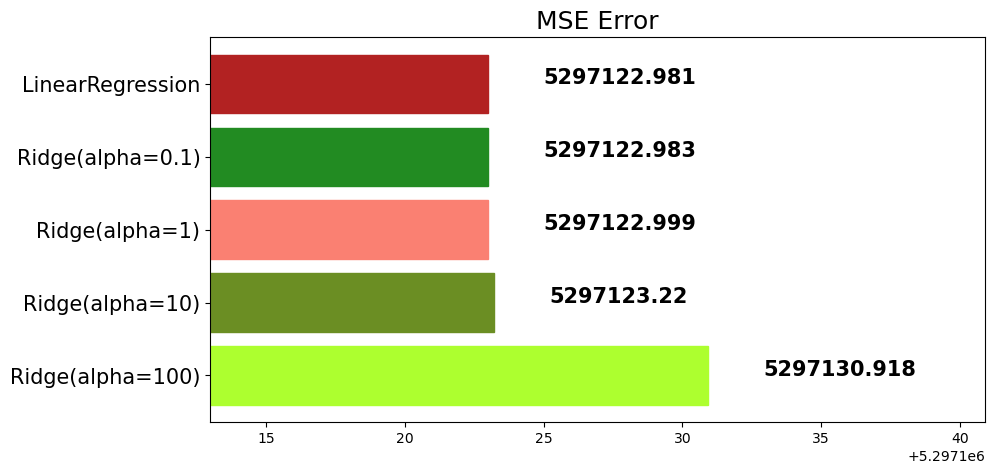

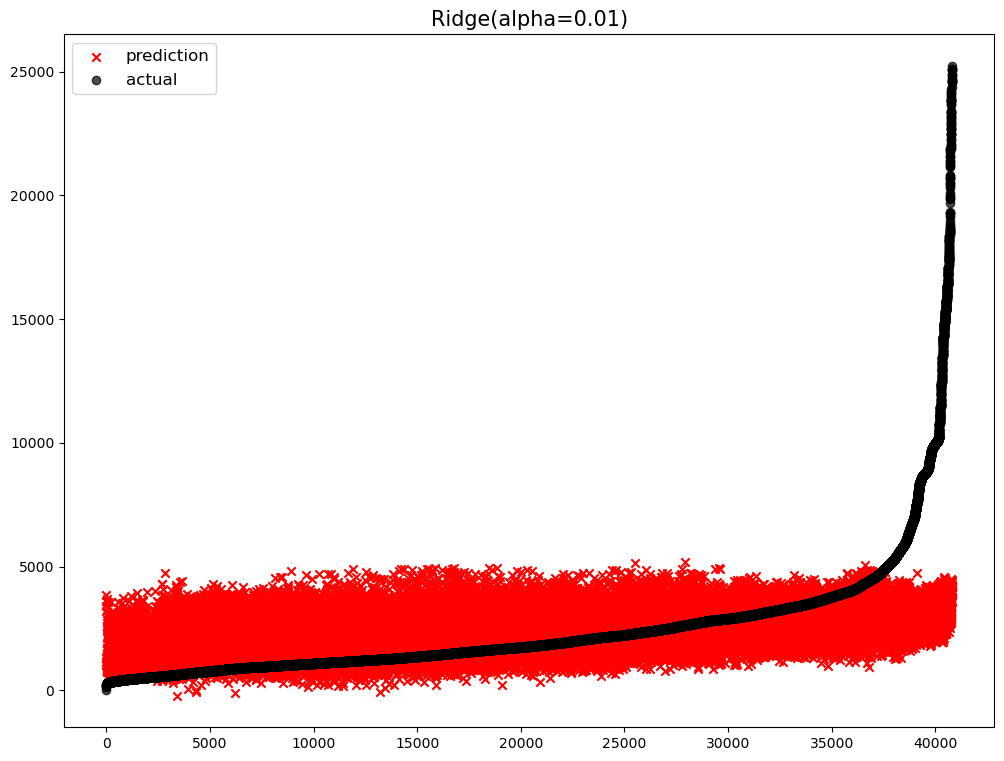

               model           mse
0   Ridge(alpha=100)  5.297131e+06
1    Ridge(alpha=10)  5.297123e+06
2     Ridge(alpha=1)  5.297123e+06
3   Ridge(alpha=0.1)  5.297123e+06
4  Ridge(alpha=0.01)  5.297123e+06
5   LinearRegression  5.297123e+06


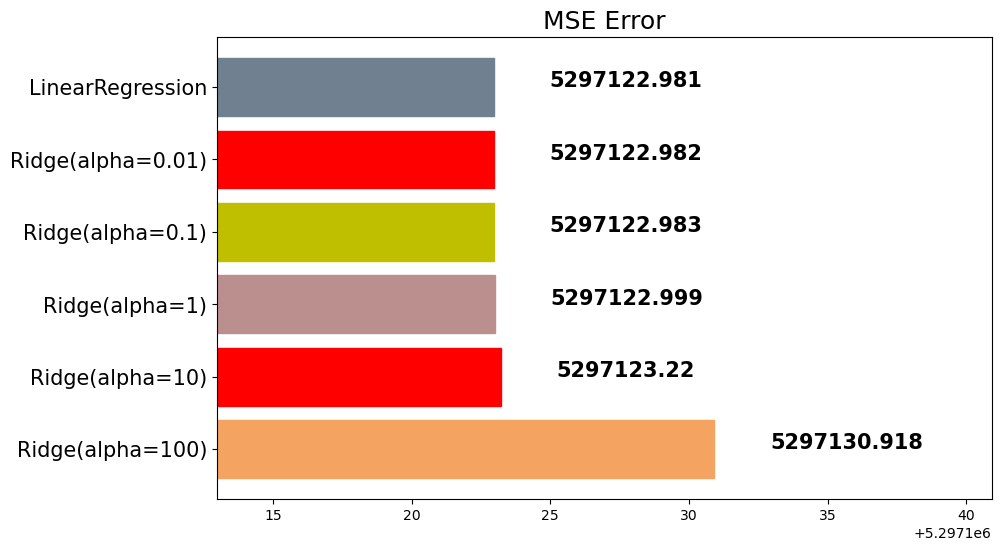

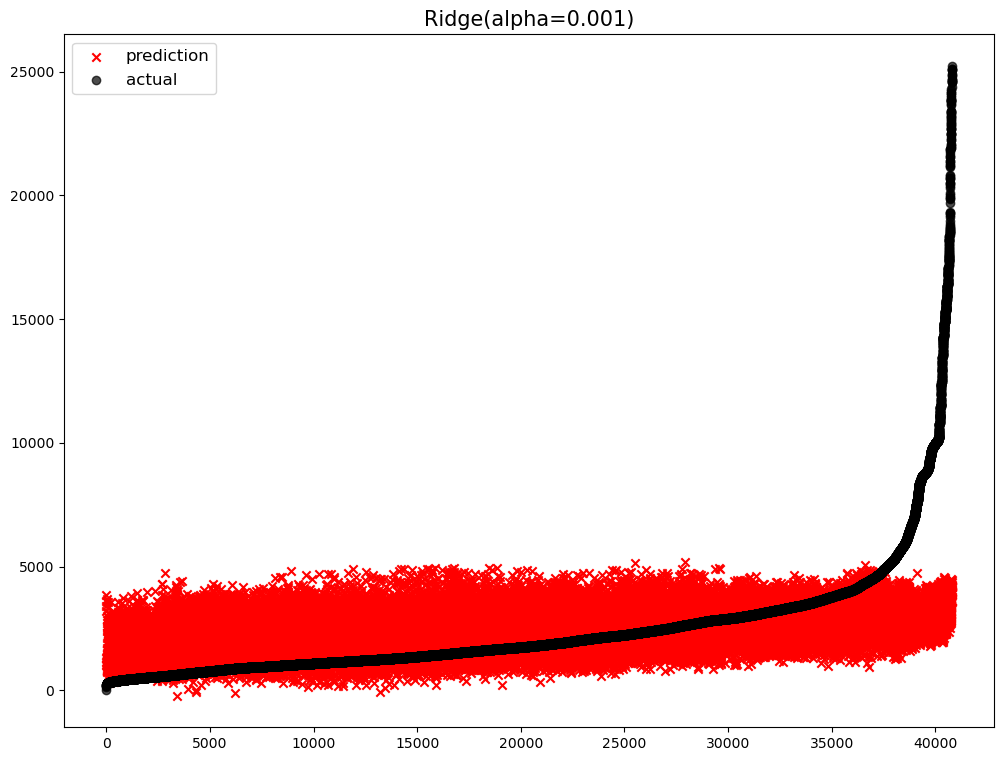

                model           mse
0    Ridge(alpha=100)  5.297131e+06
1     Ridge(alpha=10)  5.297123e+06
2      Ridge(alpha=1)  5.297123e+06
3    Ridge(alpha=0.1)  5.297123e+06
4   Ridge(alpha=0.01)  5.297123e+06
5  Ridge(alpha=0.001)  5.297123e+06
6    LinearRegression  5.297123e+06


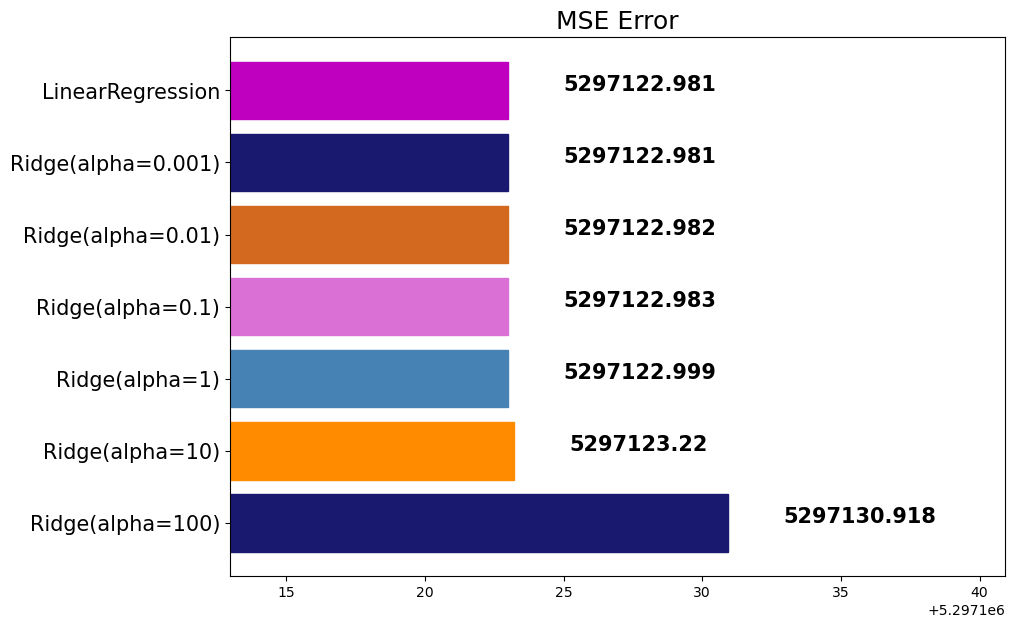

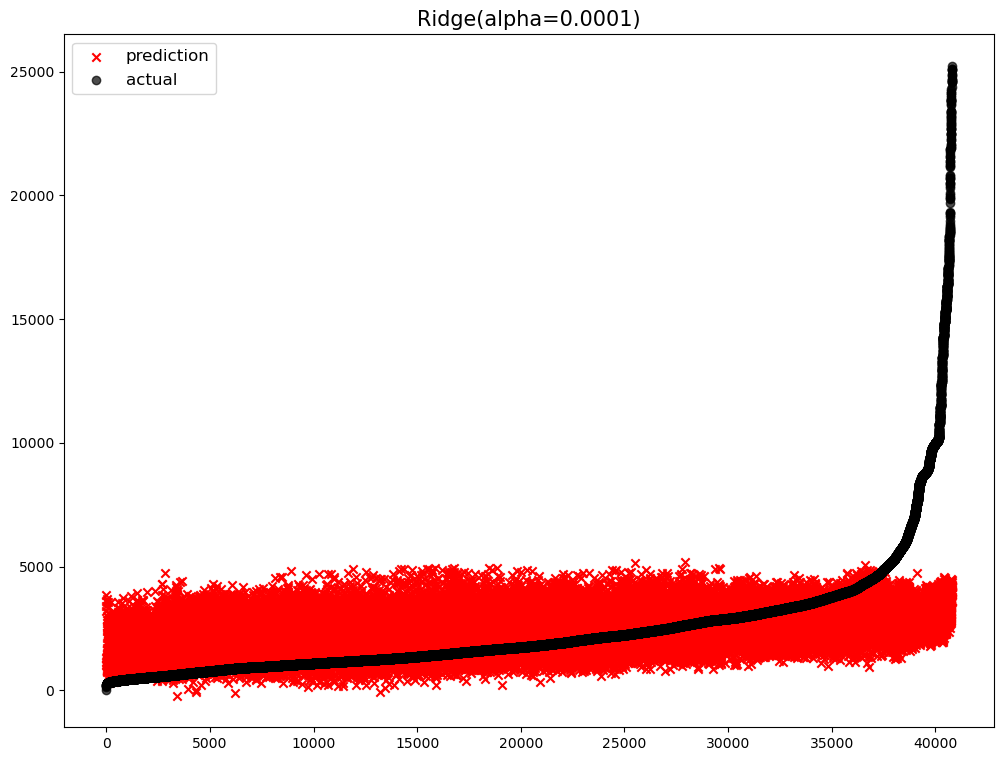

                 model           mse
0     Ridge(alpha=100)  5.297131e+06
1      Ridge(alpha=10)  5.297123e+06
2       Ridge(alpha=1)  5.297123e+06
3     Ridge(alpha=0.1)  5.297123e+06
4    Ridge(alpha=0.01)  5.297123e+06
5   Ridge(alpha=0.001)  5.297123e+06
6  Ridge(alpha=0.0001)  5.297123e+06
7     LinearRegression  5.297123e+06


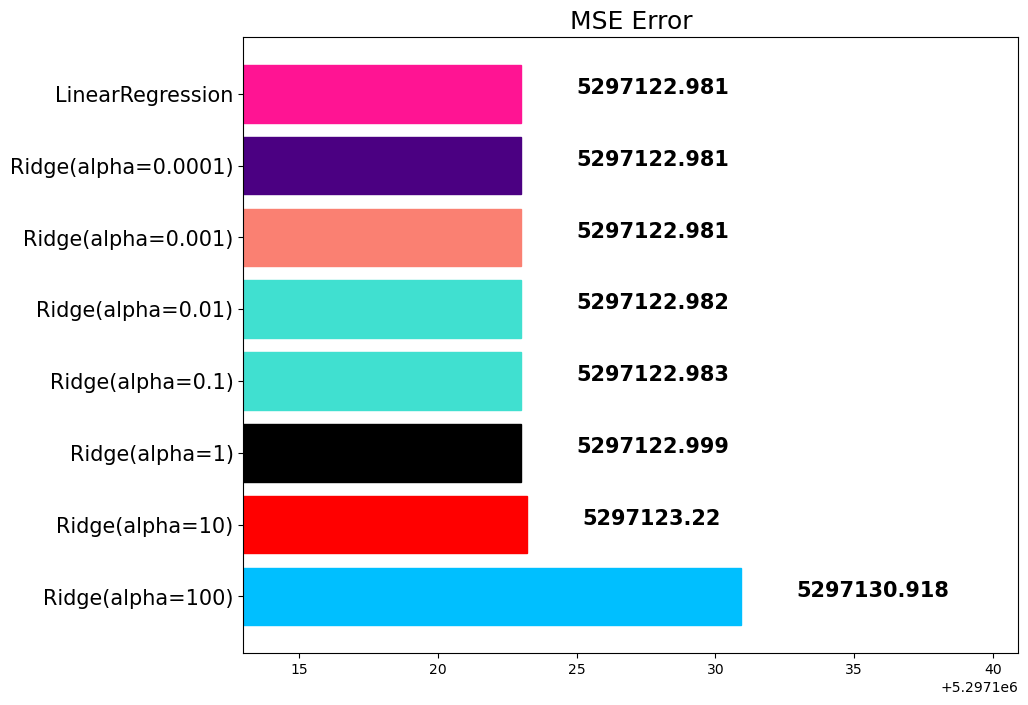

In [529]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)
    pred = ridge.predict(x_test)
    mse_eval('Ridge(alpha={})'.format(alpha), pred, y_test)

In [530]:
ridge.coef_

array([-5.47446021e+01,  4.11869437e+01,  2.87356815e+01,  8.63110817e+01,
       -9.42742662e+00, -7.59450649e+02,  5.05291603e+02,  0.00000000e+00,
        1.46024051e+02,  4.33152860e+00,  1.56073000e+01, -4.97598210e+01,
        3.07833418e+02, -2.40460646e-03,  2.84783988e-03,  1.45572278e+00,
        7.48237044e-01, -3.47185841e+00])

In [547]:
# ridge 의 alpha 값 1을 적용
ridge = Ridge(alpha=1)
ridge_pred = ridge.fit(x_train,y_train).predict(x_test)

In [531]:
# 값이 커질 수록 큰 규제입니다.
# alpha값이 커질수록 직선에 가까워진다.
alphas = [1, 0.1, 0.01, 0.001, 0.0001]

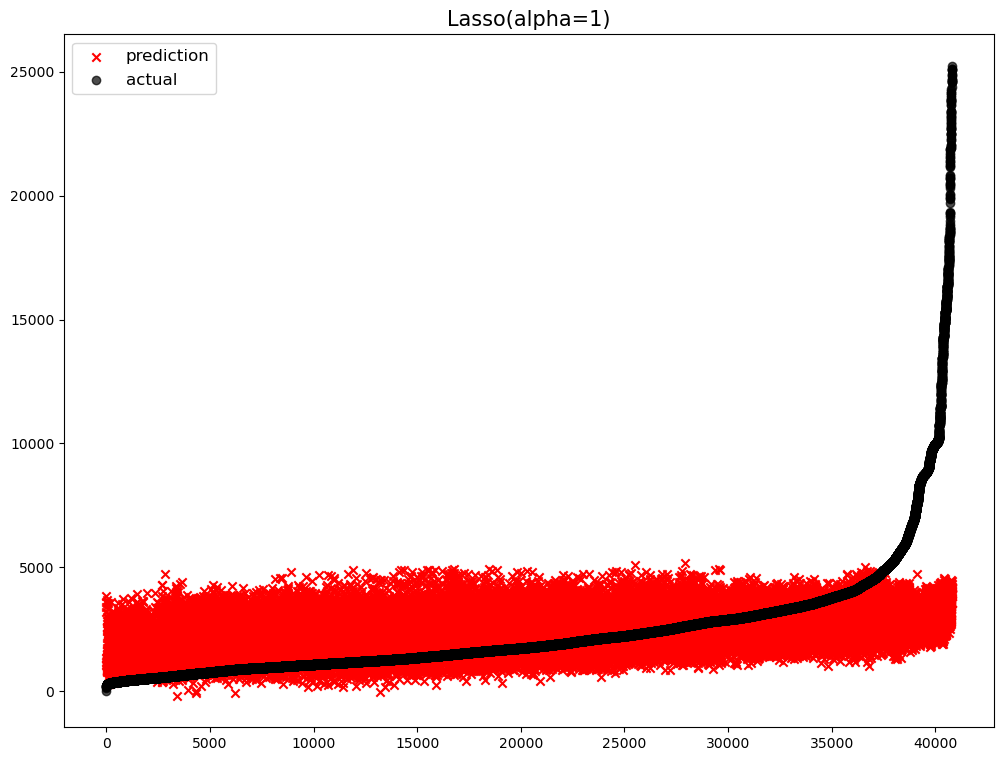

                 model           mse
0       Lasso(alpha=1)  5.297246e+06
1     Ridge(alpha=100)  5.297131e+06
2      Ridge(alpha=10)  5.297123e+06
3       Ridge(alpha=1)  5.297123e+06
4     Ridge(alpha=0.1)  5.297123e+06
5    Ridge(alpha=0.01)  5.297123e+06
6   Ridge(alpha=0.001)  5.297123e+06
7  Ridge(alpha=0.0001)  5.297123e+06
8     LinearRegression  5.297123e+06


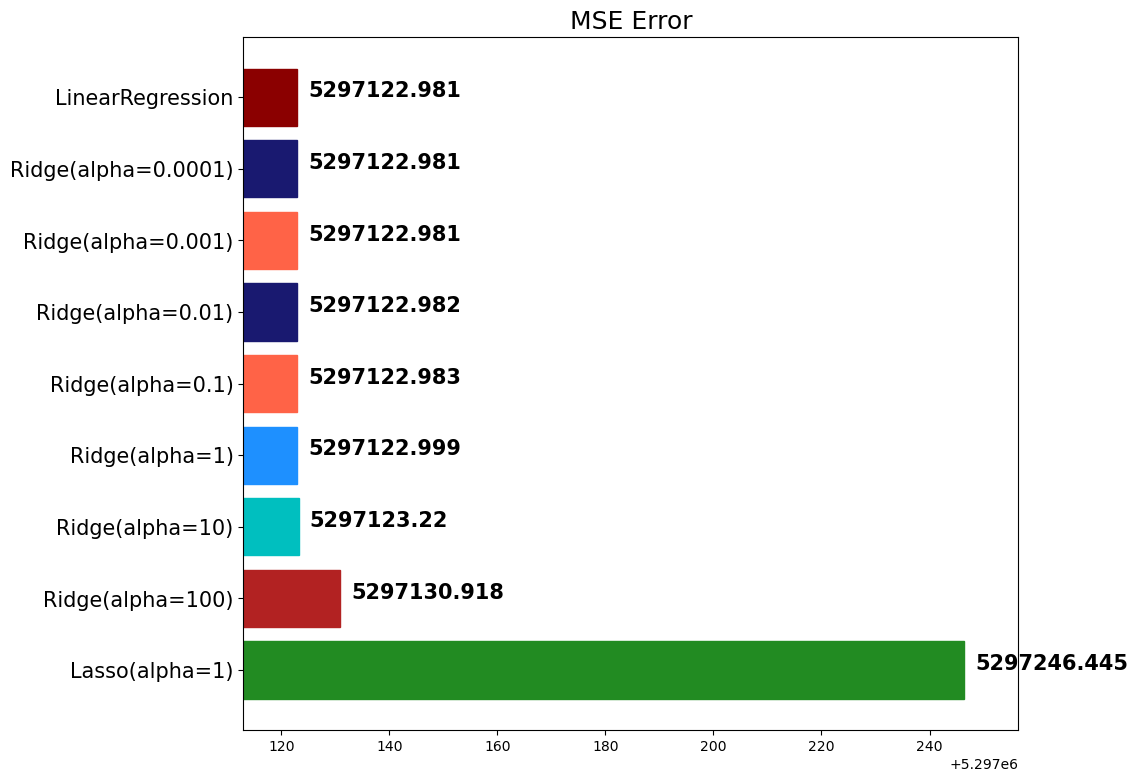

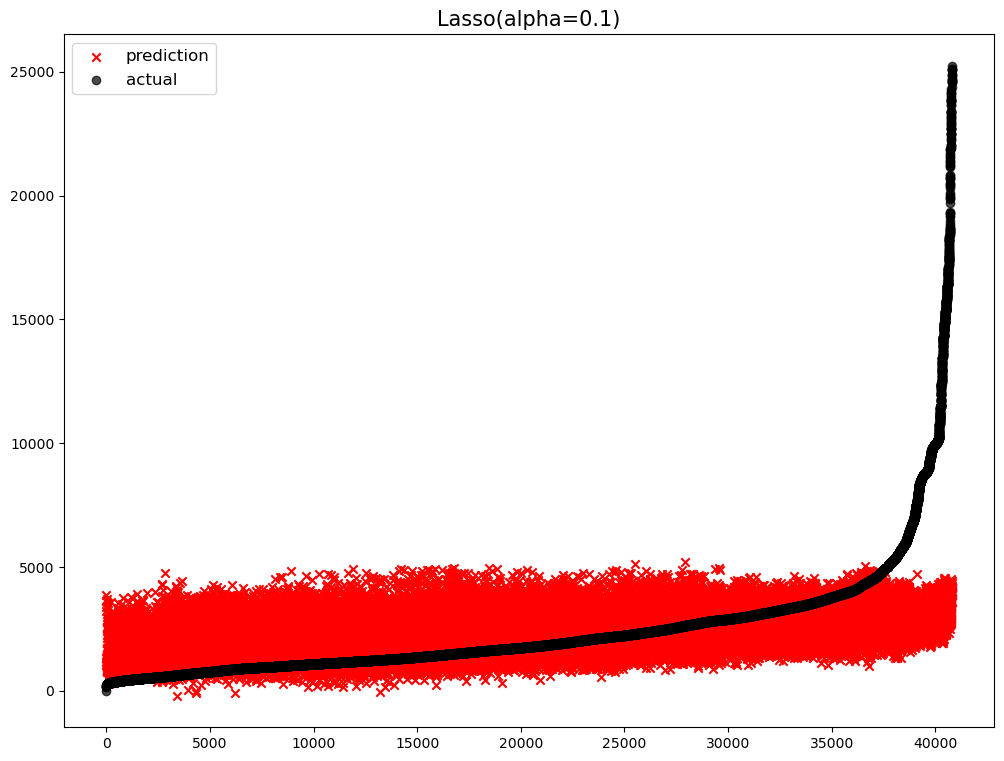

                 model           mse
0       Lasso(alpha=1)  5.297246e+06
1     Lasso(alpha=0.1)  5.297208e+06
2     Ridge(alpha=100)  5.297131e+06
3      Ridge(alpha=10)  5.297123e+06
4       Ridge(alpha=1)  5.297123e+06
5     Ridge(alpha=0.1)  5.297123e+06
6    Ridge(alpha=0.01)  5.297123e+06
7   Ridge(alpha=0.001)  5.297123e+06
8  Ridge(alpha=0.0001)  5.297123e+06
9     LinearRegression  5.297123e+06


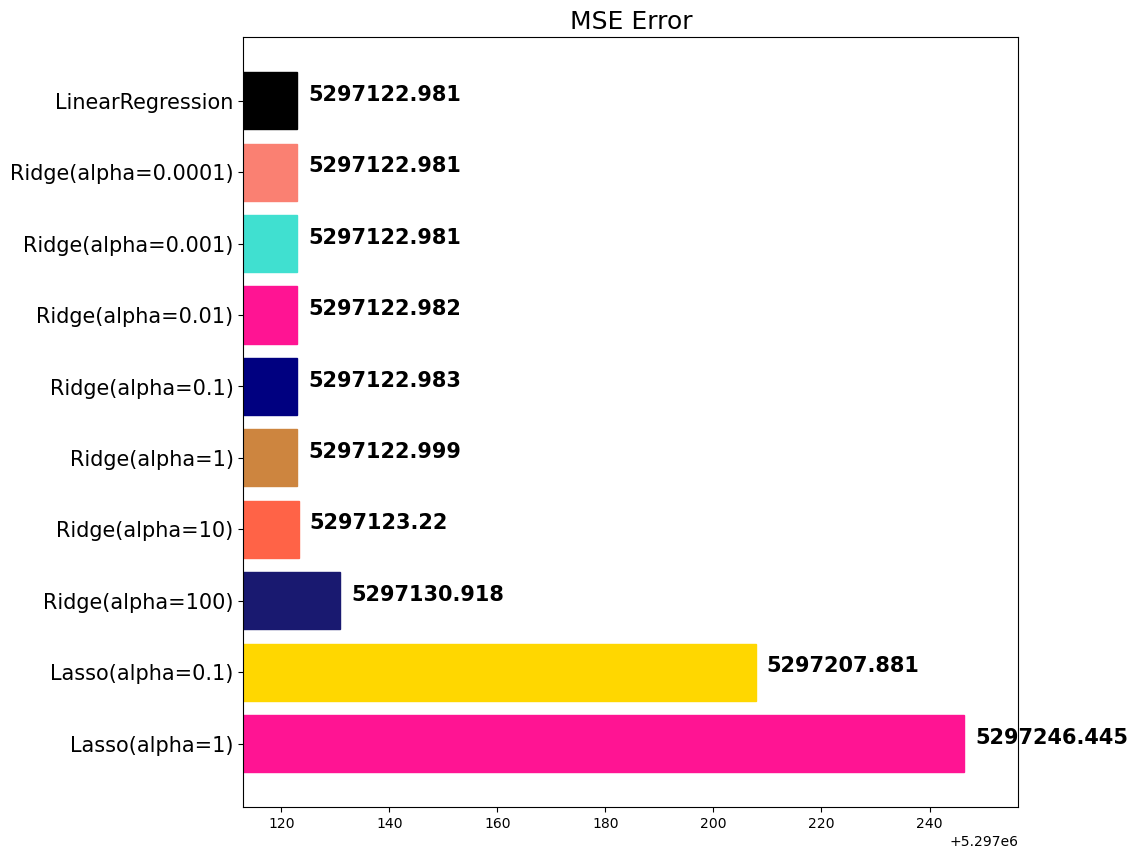

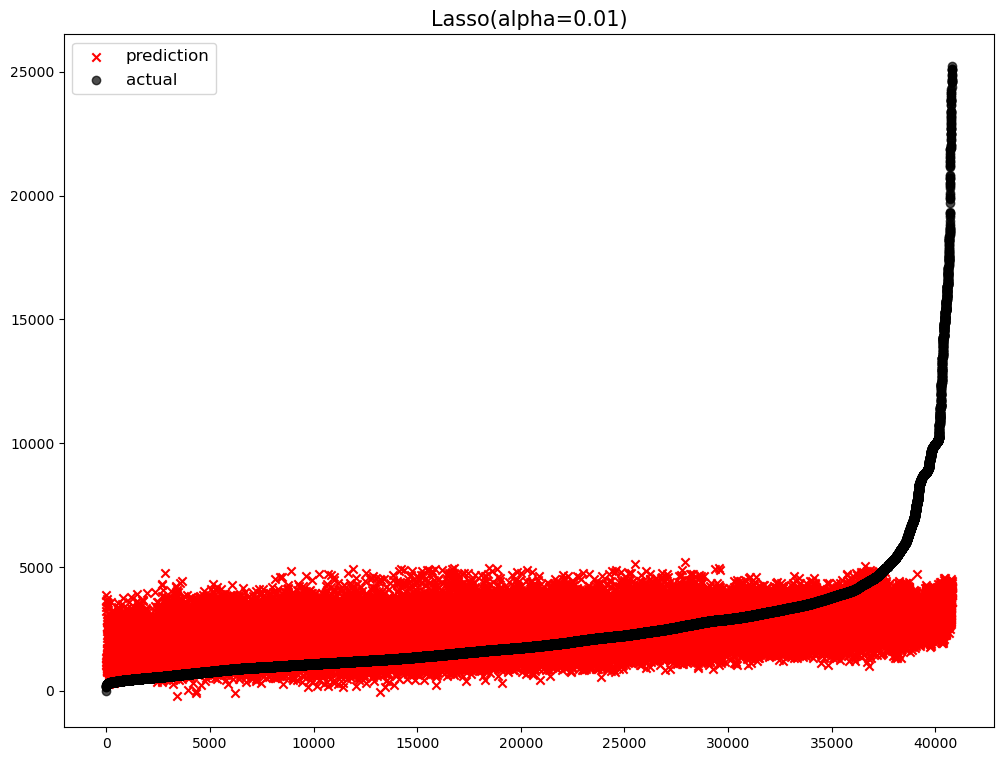

                  model           mse
0        Lasso(alpha=1)  5.297246e+06
1     Lasso(alpha=0.01)  5.297208e+06
2      Lasso(alpha=0.1)  5.297208e+06
3      Ridge(alpha=100)  5.297131e+06
4       Ridge(alpha=10)  5.297123e+06
5        Ridge(alpha=1)  5.297123e+06
6      Ridge(alpha=0.1)  5.297123e+06
7     Ridge(alpha=0.01)  5.297123e+06
8    Ridge(alpha=0.001)  5.297123e+06
9   Ridge(alpha=0.0001)  5.297123e+06
10     LinearRegression  5.297123e+06


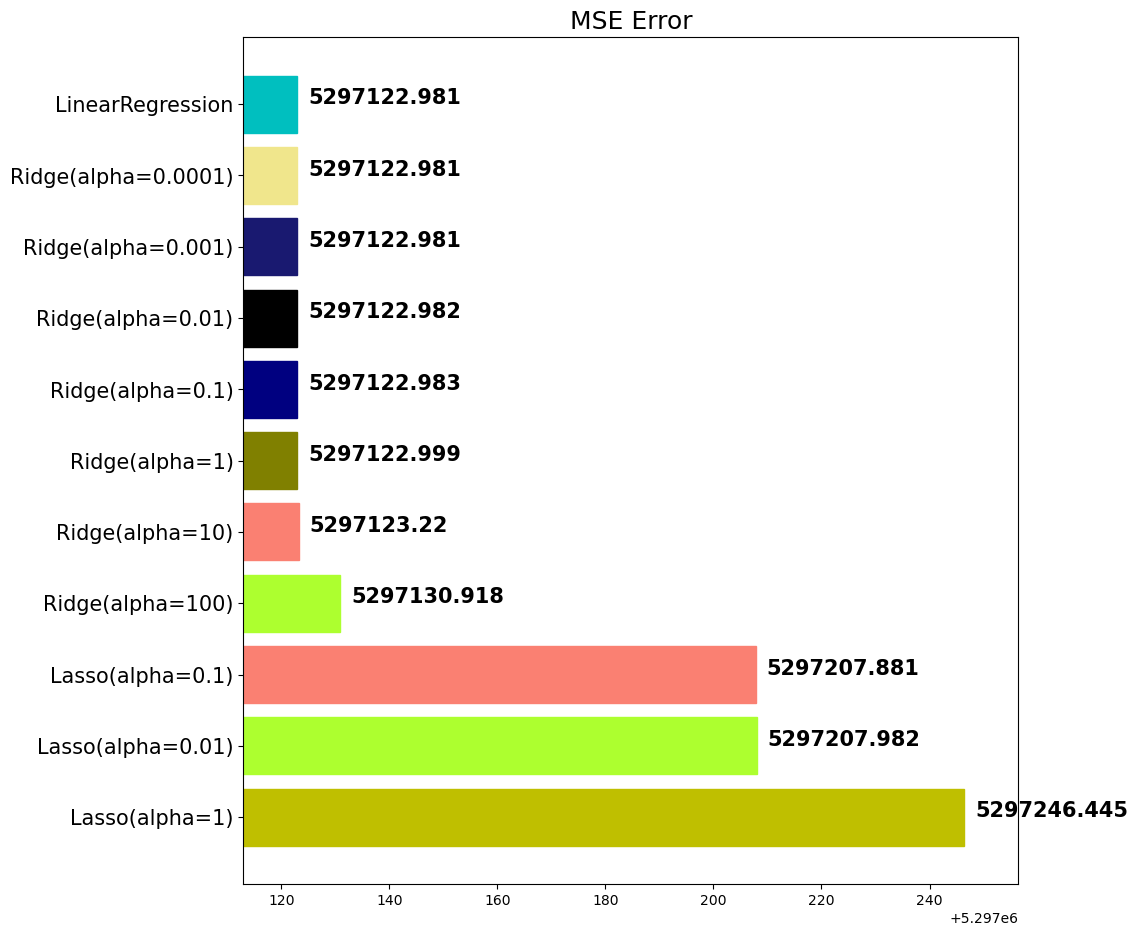

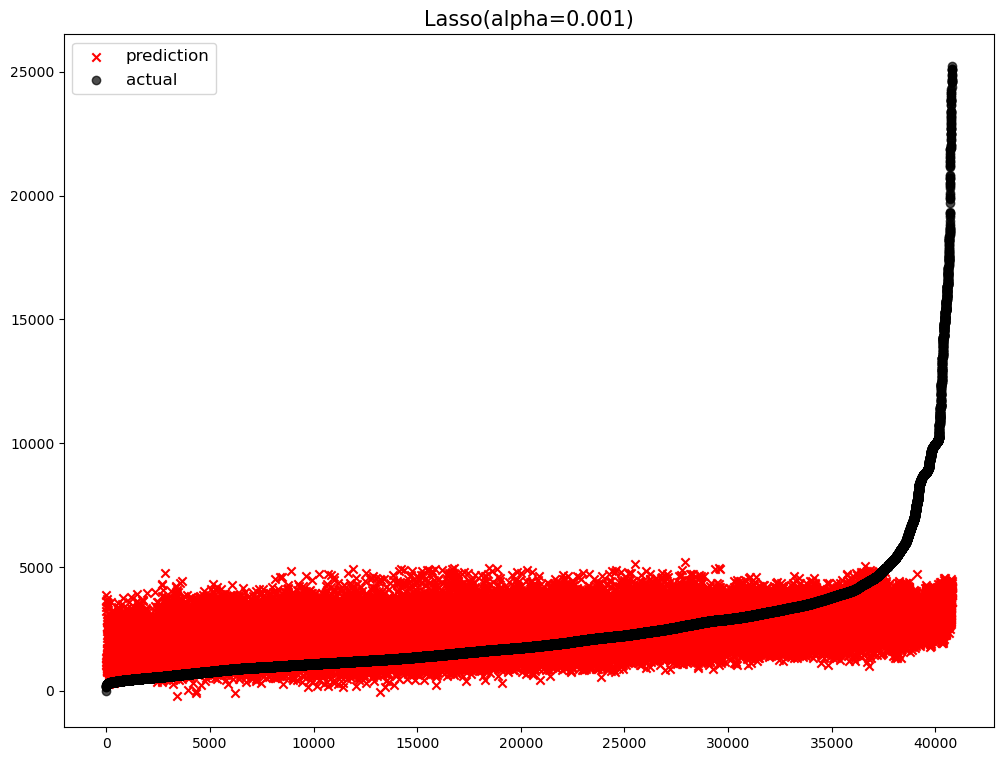

                  model           mse
0        Lasso(alpha=1)  5.297246e+06
1    Lasso(alpha=0.001)  5.297208e+06
2     Lasso(alpha=0.01)  5.297208e+06
3      Lasso(alpha=0.1)  5.297208e+06
4      Ridge(alpha=100)  5.297131e+06
5       Ridge(alpha=10)  5.297123e+06
6        Ridge(alpha=1)  5.297123e+06
7      Ridge(alpha=0.1)  5.297123e+06
8     Ridge(alpha=0.01)  5.297123e+06
9    Ridge(alpha=0.001)  5.297123e+06
10  Ridge(alpha=0.0001)  5.297123e+06
11     LinearRegression  5.297123e+06


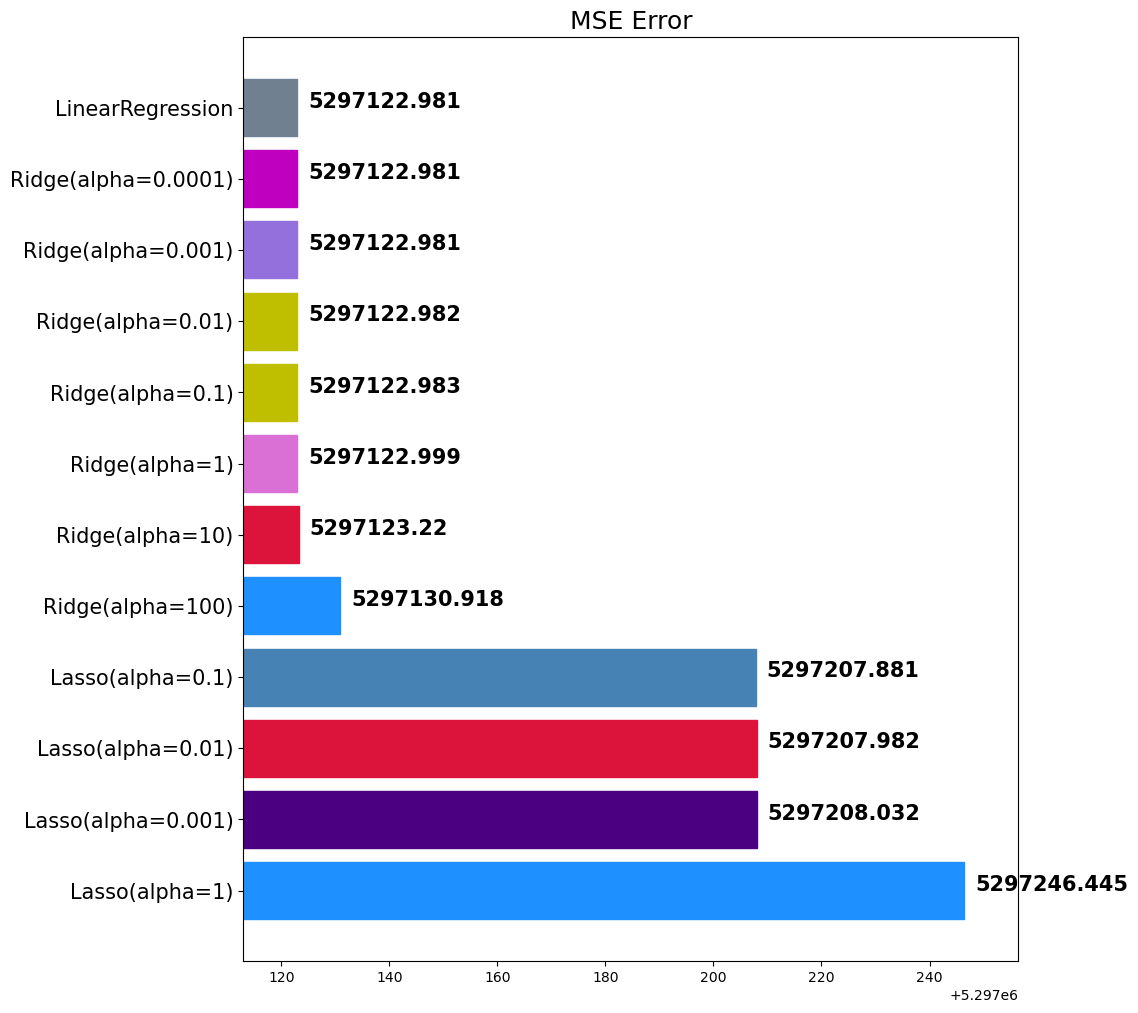

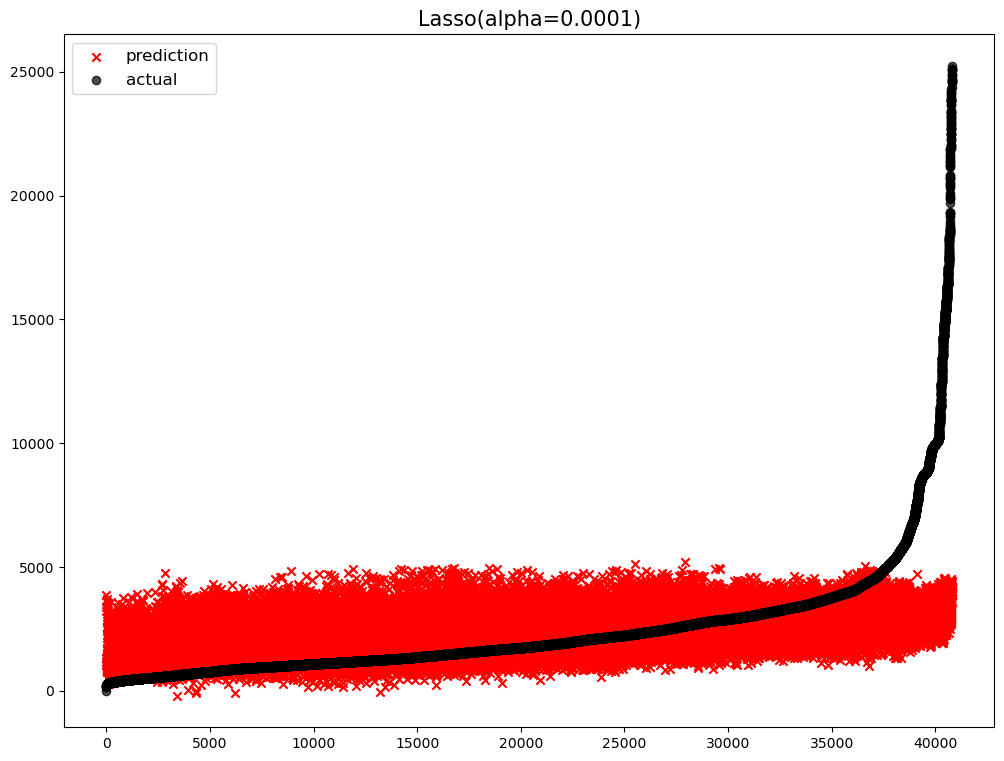

                  model           mse
0        Lasso(alpha=1)  5.297246e+06
1   Lasso(alpha=0.0001)  5.297208e+06
2    Lasso(alpha=0.001)  5.297208e+06
3     Lasso(alpha=0.01)  5.297208e+06
4      Lasso(alpha=0.1)  5.297208e+06
5      Ridge(alpha=100)  5.297131e+06
6       Ridge(alpha=10)  5.297123e+06
7        Ridge(alpha=1)  5.297123e+06
8      Ridge(alpha=0.1)  5.297123e+06
9     Ridge(alpha=0.01)  5.297123e+06
10   Ridge(alpha=0.001)  5.297123e+06
11  Ridge(alpha=0.0001)  5.297123e+06
12     LinearRegression  5.297123e+06


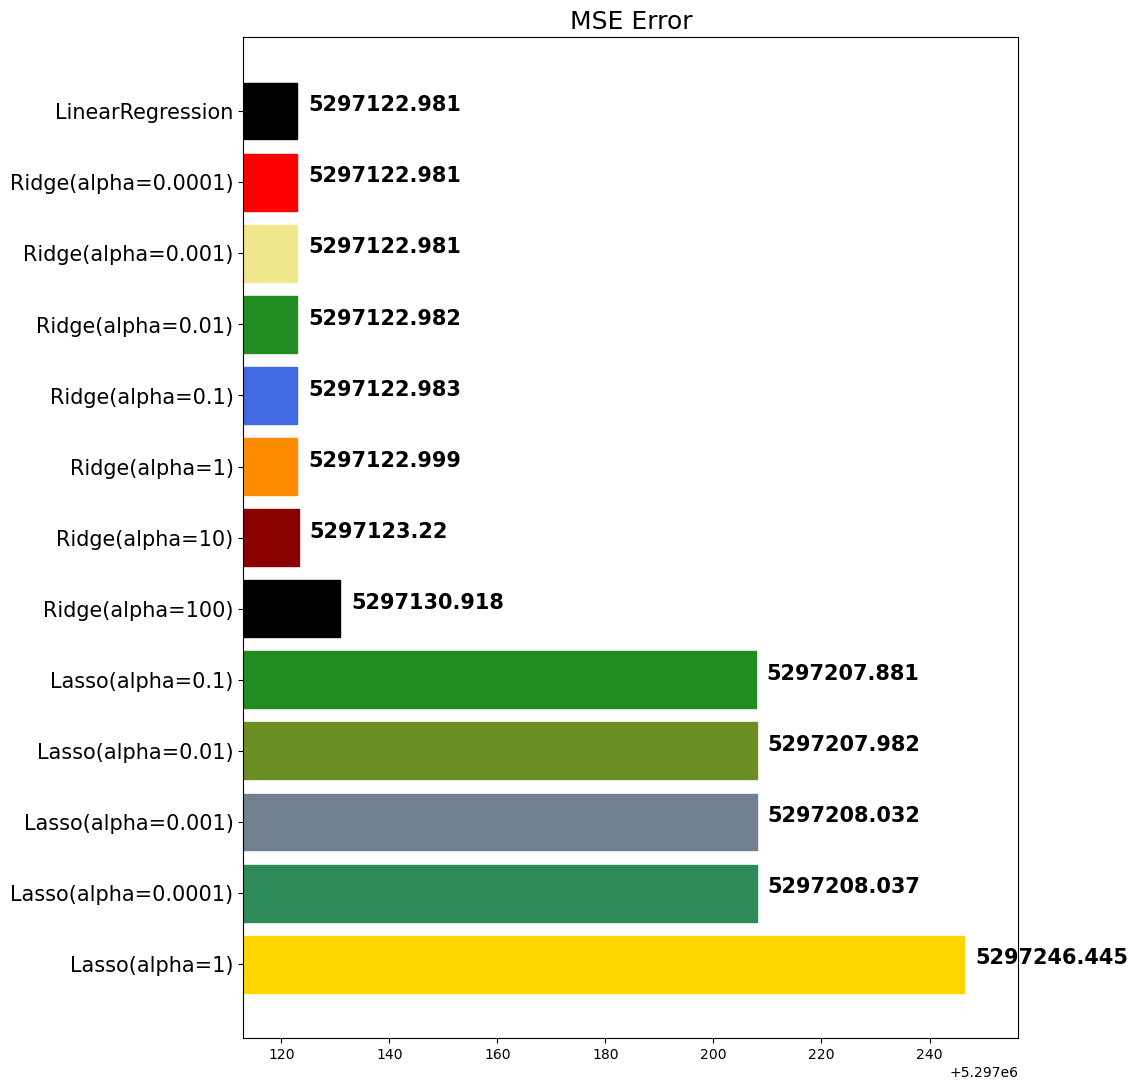

In [532]:
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)
    pred = lasso.predict(x_test)
    mse_eval('Lasso(alpha={})'.format(alpha), pred, y_test)

In [548]:
# Lasso에 alpha 값 0.1을 적용
lasso = Lasso(alpha=0.1)
lasso_pred = lasso.fit(x_train, y_train).predict(x_test)

In [533]:
# ratios가 수식의 r이다.
ratios = [0.2, 0.5, 0.8]

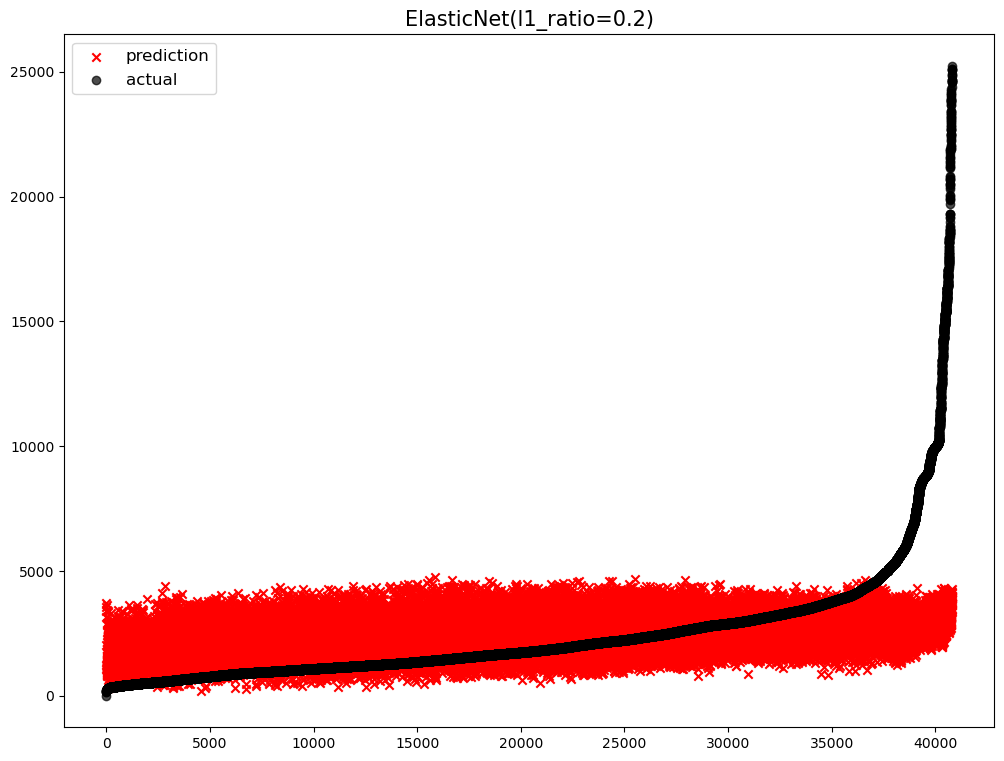

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1             Lasso(alpha=1)  5.297246e+06
2        Lasso(alpha=0.0001)  5.297208e+06
3         Lasso(alpha=0.001)  5.297208e+06
4          Lasso(alpha=0.01)  5.297208e+06
5           Lasso(alpha=0.1)  5.297208e+06
6           Ridge(alpha=100)  5.297131e+06
7            Ridge(alpha=10)  5.297123e+06
8             Ridge(alpha=1)  5.297123e+06
9           Ridge(alpha=0.1)  5.297123e+06
10         Ridge(alpha=0.01)  5.297123e+06
11        Ridge(alpha=0.001)  5.297123e+06
12       Ridge(alpha=0.0001)  5.297123e+06
13          LinearRegression  5.297123e+06


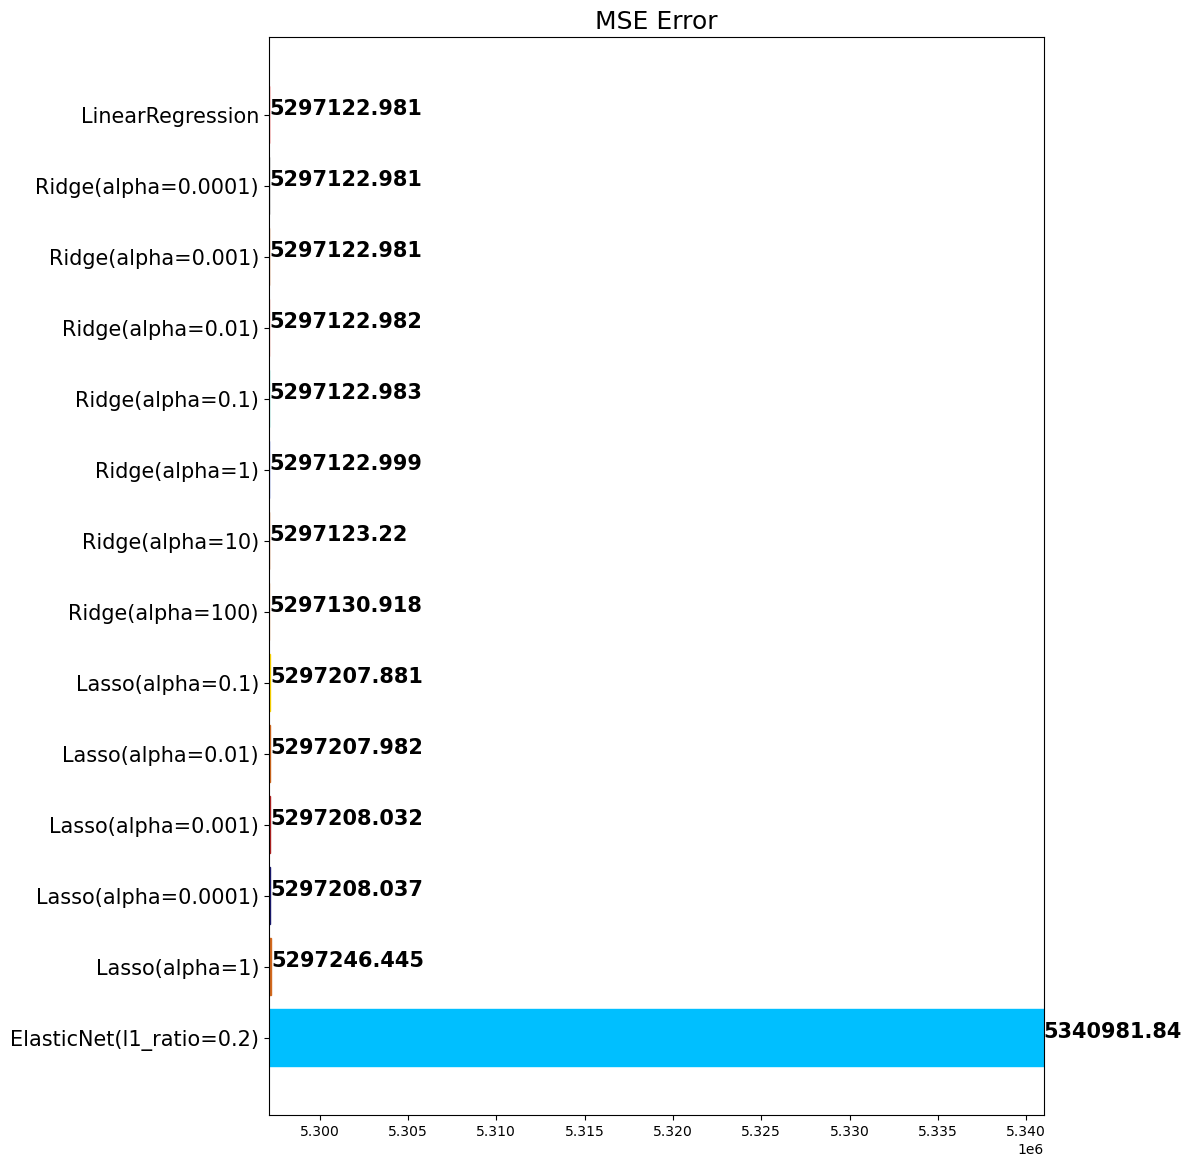

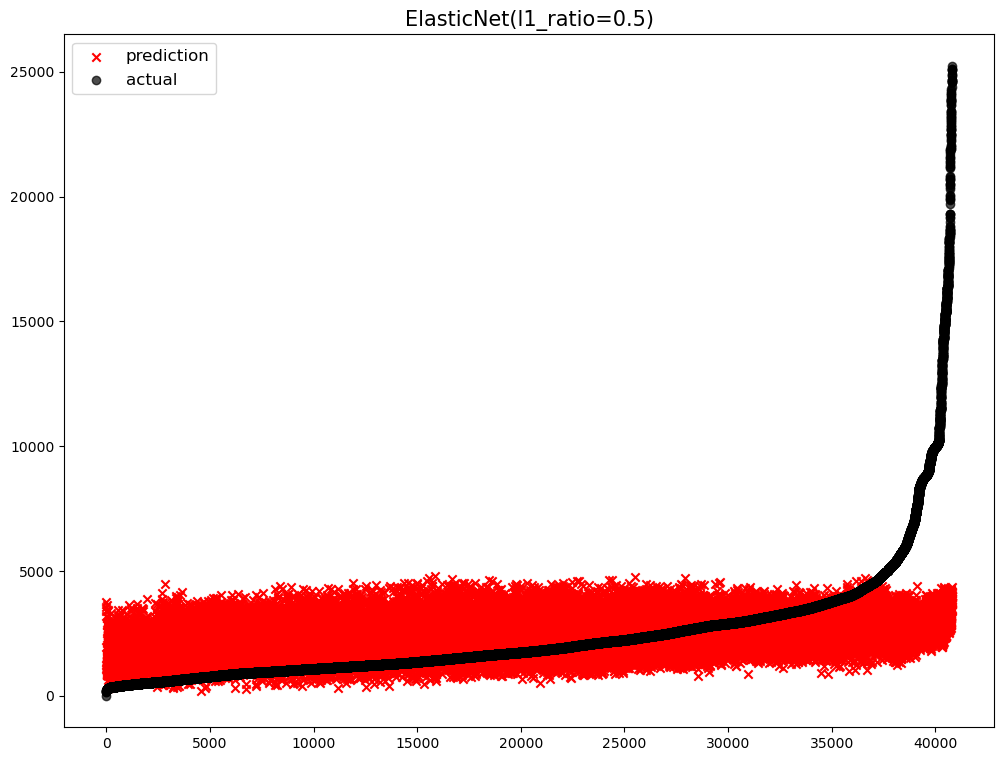

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1   ElasticNet(l1_ratio=0.5)  5.332211e+06
2             Lasso(alpha=1)  5.297246e+06
3        Lasso(alpha=0.0001)  5.297208e+06
4         Lasso(alpha=0.001)  5.297208e+06
5          Lasso(alpha=0.01)  5.297208e+06
6           Lasso(alpha=0.1)  5.297208e+06
7           Ridge(alpha=100)  5.297131e+06
8            Ridge(alpha=10)  5.297123e+06
9             Ridge(alpha=1)  5.297123e+06
10          Ridge(alpha=0.1)  5.297123e+06
11         Ridge(alpha=0.01)  5.297123e+06
12        Ridge(alpha=0.001)  5.297123e+06
13       Ridge(alpha=0.0001)  5.297123e+06
14          LinearRegression  5.297123e+06


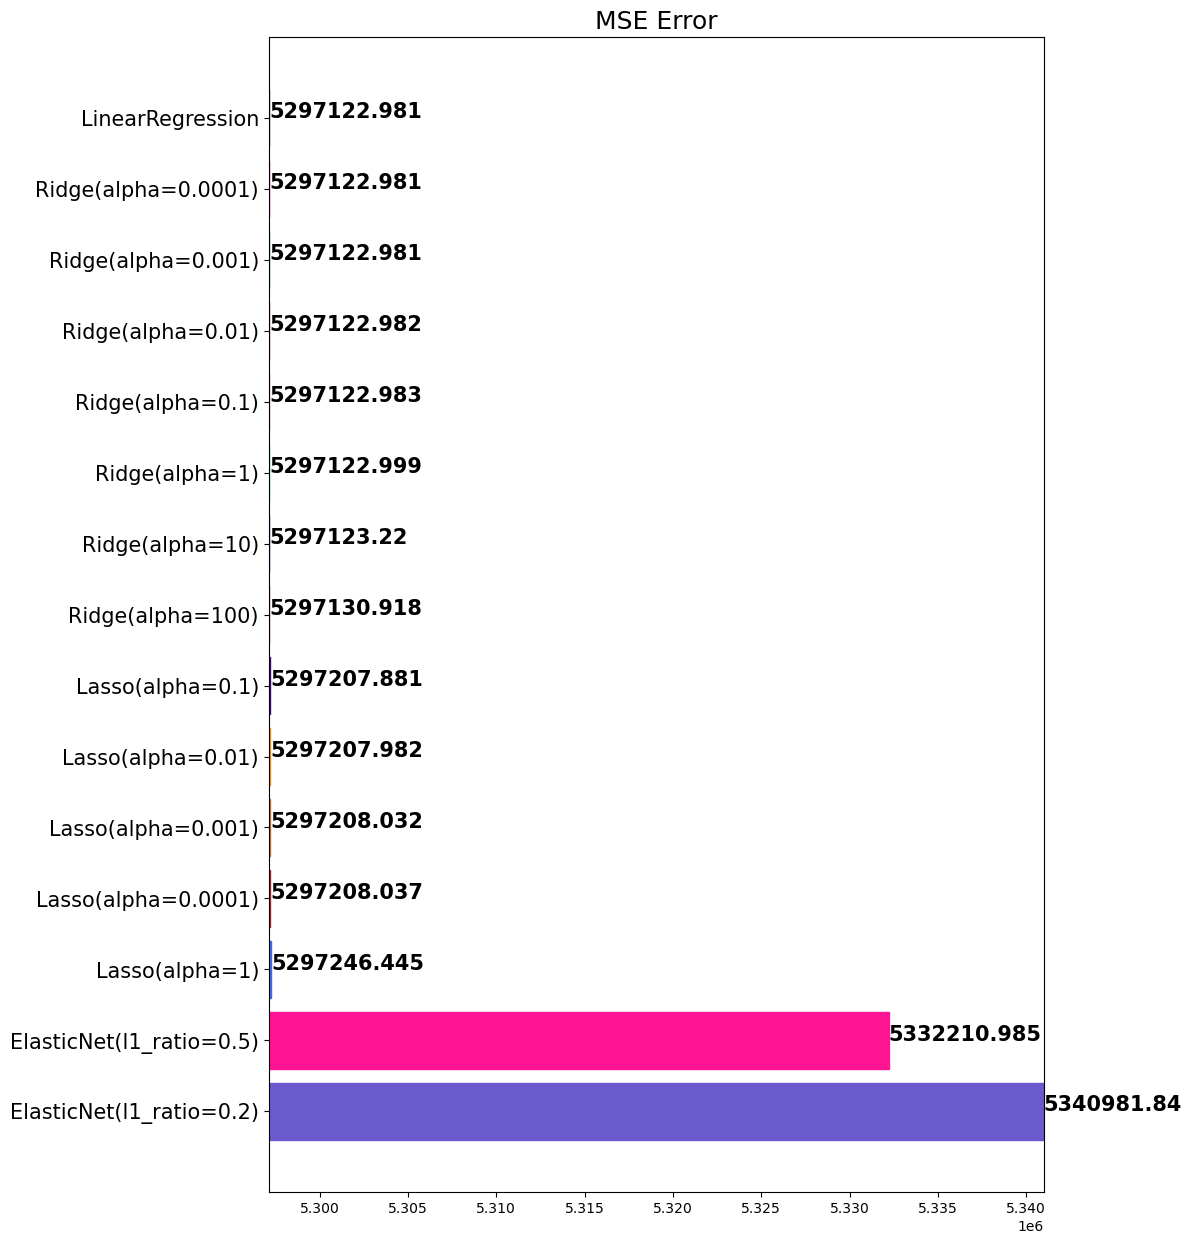

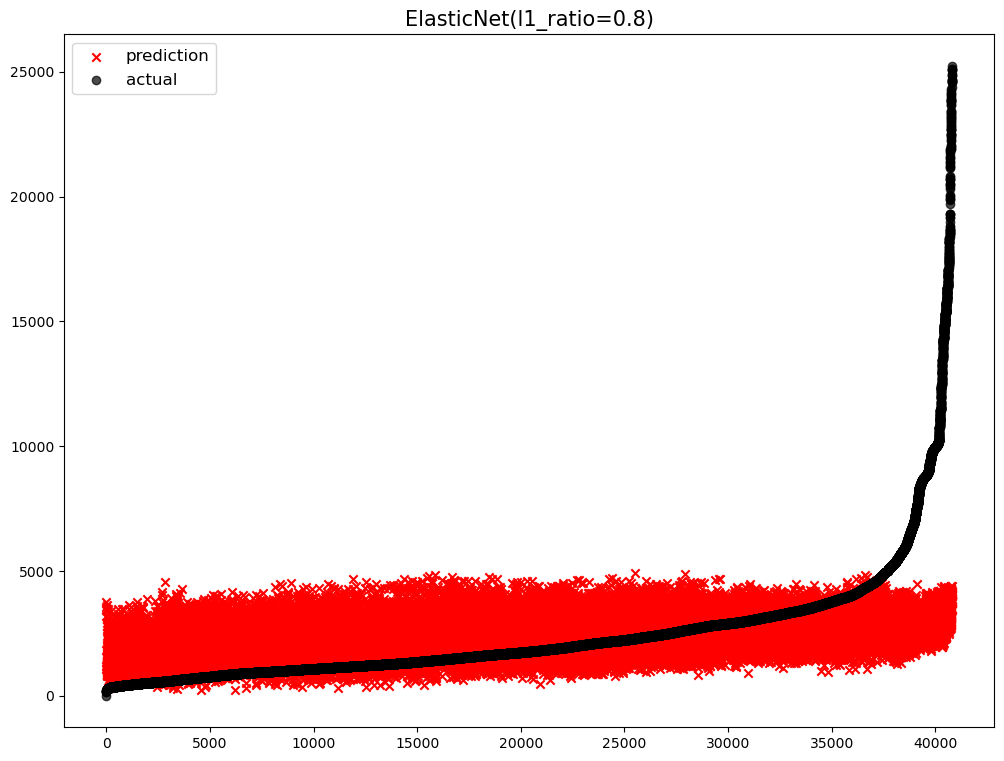

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1   ElasticNet(l1_ratio=0.5)  5.332211e+06
2   ElasticNet(l1_ratio=0.8)  5.317005e+06
3             Lasso(alpha=1)  5.297246e+06
4        Lasso(alpha=0.0001)  5.297208e+06
5         Lasso(alpha=0.001)  5.297208e+06
6          Lasso(alpha=0.01)  5.297208e+06
7           Lasso(alpha=0.1)  5.297208e+06
8           Ridge(alpha=100)  5.297131e+06
9            Ridge(alpha=10)  5.297123e+06
10            Ridge(alpha=1)  5.297123e+06
11          Ridge(alpha=0.1)  5.297123e+06
12         Ridge(alpha=0.01)  5.297123e+06
13        Ridge(alpha=0.001)  5.297123e+06
14       Ridge(alpha=0.0001)  5.297123e+06
15          LinearRegression  5.297123e+06


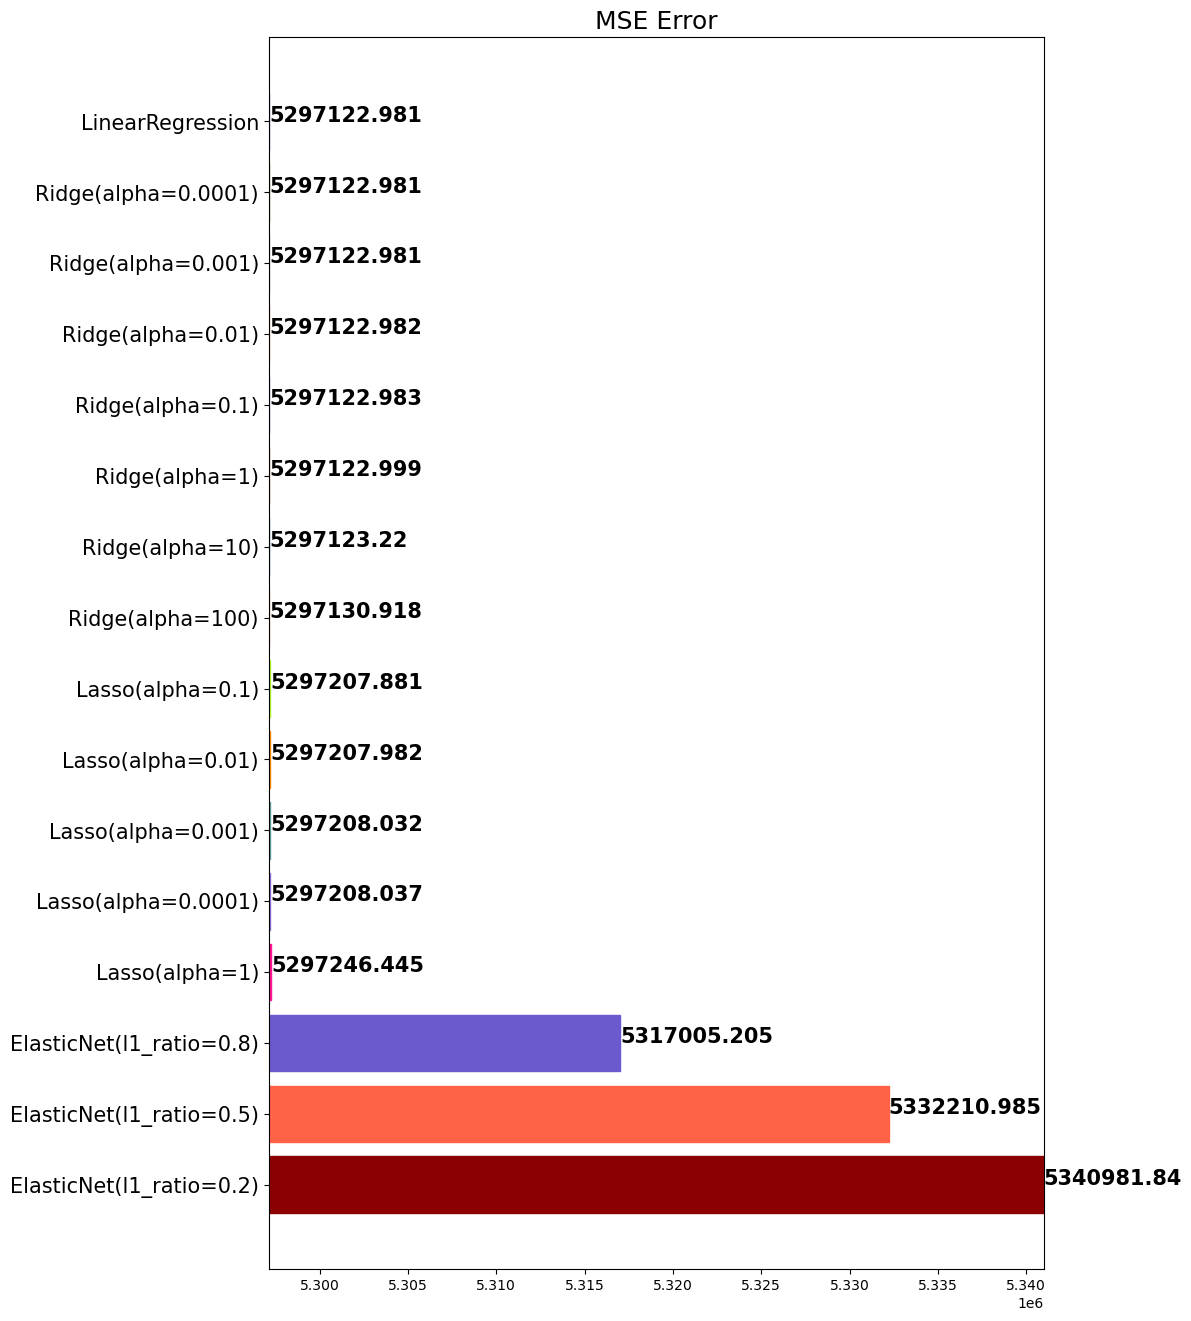

In [534]:
for ratio in ratios:
    elasticnet = ElasticNet(alpha=0.5, l1_ratio=ratio)
    elasticnet.fit(x_train, y_train)
    pred = elasticnet.predict(x_test)
    mse_eval('ElasticNet(l1_ratio={})'.format(ratio), pred, y_test)

In [549]:
# ElasticNet에 Ration 0.8 적용
elasticnet = ElasticNet(alpha=0.5, l1_ratio=0.8)
elasticnet_pred = elasticnet.fit(x_train, y_train).predict(x_test)

In [535]:
std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(x_train)
round(pd.DataFrame(std_scaled).describe(), 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.0,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00
mean,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.0,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-4.08,-0.17,-1.57,-5.22,-0.59,-0.66,0.0,-1.17,-1.64,-1.66,-1.50,-1.43,-0.20,-0.17,-0.40,-0.20,-0.21
25%,-0.85,-0.57,-0.17,-0.69,-0.65,-0.59,-0.66,0.0,-1.17,-0.81,-0.94,-1.00,-0.88,-0.16,-0.15,-0.40,-0.20,-0.21
50%,0.02,0.04,-0.17,-0.10,0.15,-0.59,-0.61,0.0,0.09,0.02,0.07,0.01,-0.05,-0.13,-0.12,-0.40,-0.20,-0.21
75%,0.88,0.68,-0.17,0.49,0.81,0.25,0.35,0.0,1.35,0.85,0.80,1.01,0.77,-0.06,-0.08,-0.06,-0.20,-0.21
max,1.72,3.05,36.55,8.21,1.41,2.21,3.60,0.0,1.35,1.91,1.66,1.51,1.59,9.87,9.88,6.51,6.98,6.63


In [536]:
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(x_train)
round(pd.DataFrame(minmax_scaled).describe(), 2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.0,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00,163200.00
mean,0.50,0.57,0.00,0.16,0.79,0.21,0.15,0.0,0.47,0.46,0.50,0.50,0.47,0.02,0.02,0.06,0.03,0.03
std,0.29,0.14,0.03,0.10,0.15,0.36,0.23,0.0,0.40,0.28,0.30,0.33,0.33,0.10,0.10,0.14,0.14,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.49,0.00,0.09,0.69,0.00,0.00,0.0,0.00,0.23,0.22,0.17,0.18,0.00,0.00,0.00,0.00,0.00
50%,0.51,0.58,0.00,0.15,0.81,0.00,0.01,0.0,0.50,0.47,0.52,0.50,0.45,0.01,0.01,0.00,0.00,0.00
75%,0.76,0.67,0.00,0.21,0.91,0.30,0.24,0.0,1.00,0.70,0.74,0.83,0.73,0.01,0.01,0.05,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [537]:
robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(x_train)
round(pd.DataFrame(robust_scaled).median(), 2)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
dtype: float64

In [538]:
elasticnet_pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)

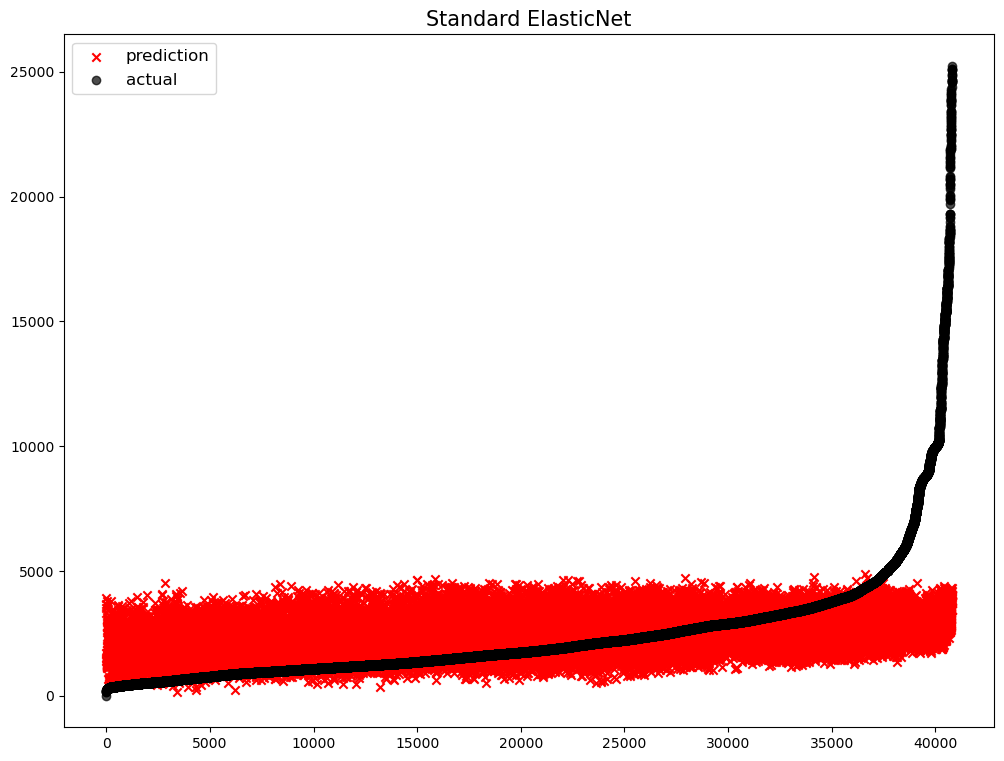

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1        Standard ElasticNet  5.340226e+06
2   ElasticNet(l1_ratio=0.5)  5.332211e+06
3   ElasticNet(l1_ratio=0.8)  5.317005e+06
4             Lasso(alpha=1)  5.297246e+06
5        Lasso(alpha=0.0001)  5.297208e+06
6         Lasso(alpha=0.001)  5.297208e+06
7          Lasso(alpha=0.01)  5.297208e+06
8           Lasso(alpha=0.1)  5.297208e+06
9           Ridge(alpha=100)  5.297131e+06
10           Ridge(alpha=10)  5.297123e+06
11            Ridge(alpha=1)  5.297123e+06
12          Ridge(alpha=0.1)  5.297123e+06
13         Ridge(alpha=0.01)  5.297123e+06
14        Ridge(alpha=0.001)  5.297123e+06
15       Ridge(alpha=0.0001)  5.297123e+06
16          LinearRegression  5.297123e+06


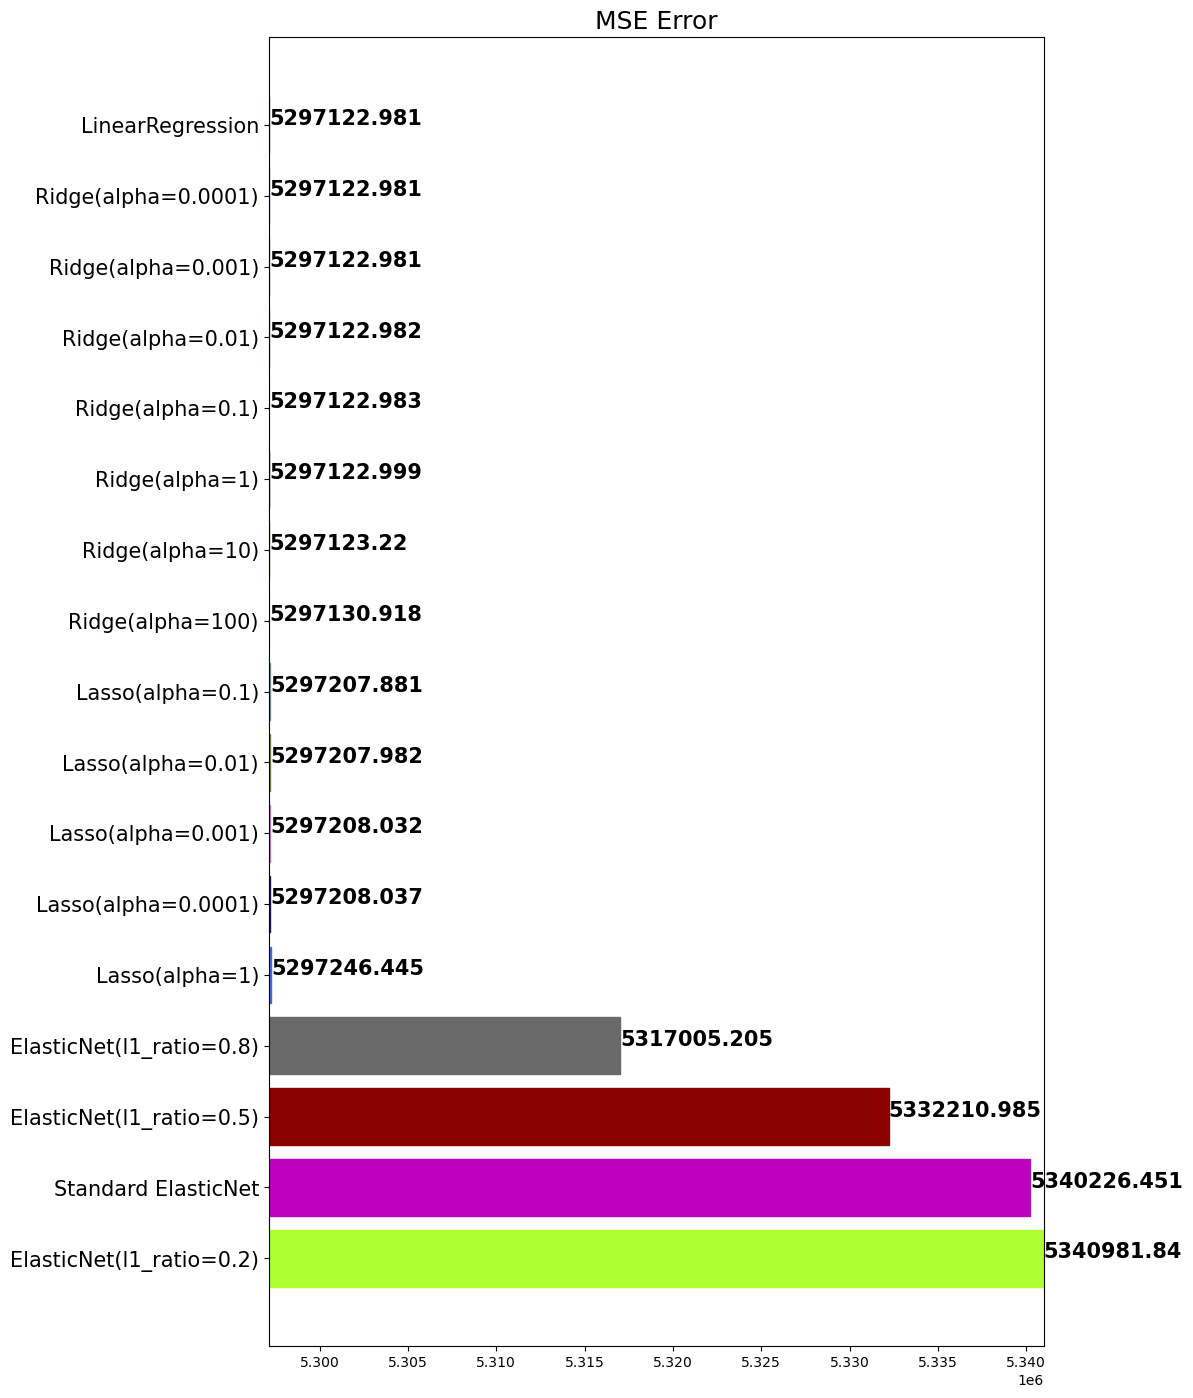

In [539]:
elasticnet_pipeline.fit(x_train, y_train)
pred = elasticnet_pipeline.predict(x_test)
mse_eval('Standard ElasticNet', pred, y_test)

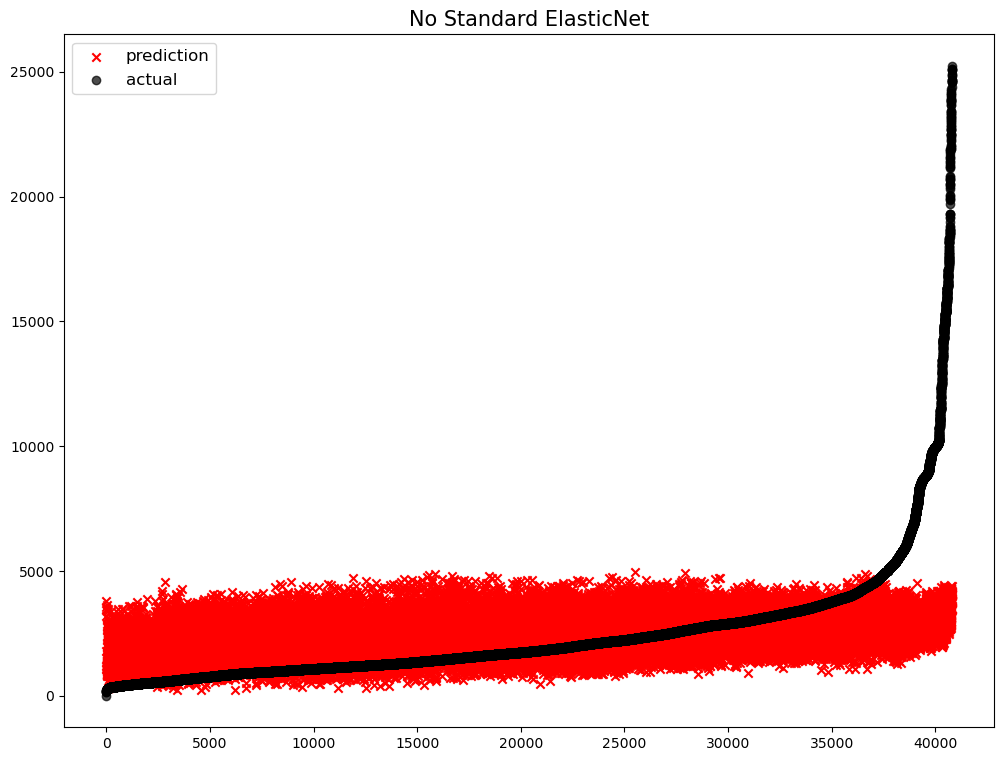

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1        Standard ElasticNet  5.340226e+06
2   ElasticNet(l1_ratio=0.5)  5.332211e+06
3   ElasticNet(l1_ratio=0.8)  5.317005e+06
4     No Standard ElasticNet  5.313519e+06
5             Lasso(alpha=1)  5.297246e+06
6        Lasso(alpha=0.0001)  5.297208e+06
7         Lasso(alpha=0.001)  5.297208e+06
8          Lasso(alpha=0.01)  5.297208e+06
9           Lasso(alpha=0.1)  5.297208e+06
10          Ridge(alpha=100)  5.297131e+06
11           Ridge(alpha=10)  5.297123e+06
12            Ridge(alpha=1)  5.297123e+06
13          Ridge(alpha=0.1)  5.297123e+06
14         Ridge(alpha=0.01)  5.297123e+06
15        Ridge(alpha=0.001)  5.297123e+06
16       Ridge(alpha=0.0001)  5.297123e+06
17          LinearRegression  5.297123e+06


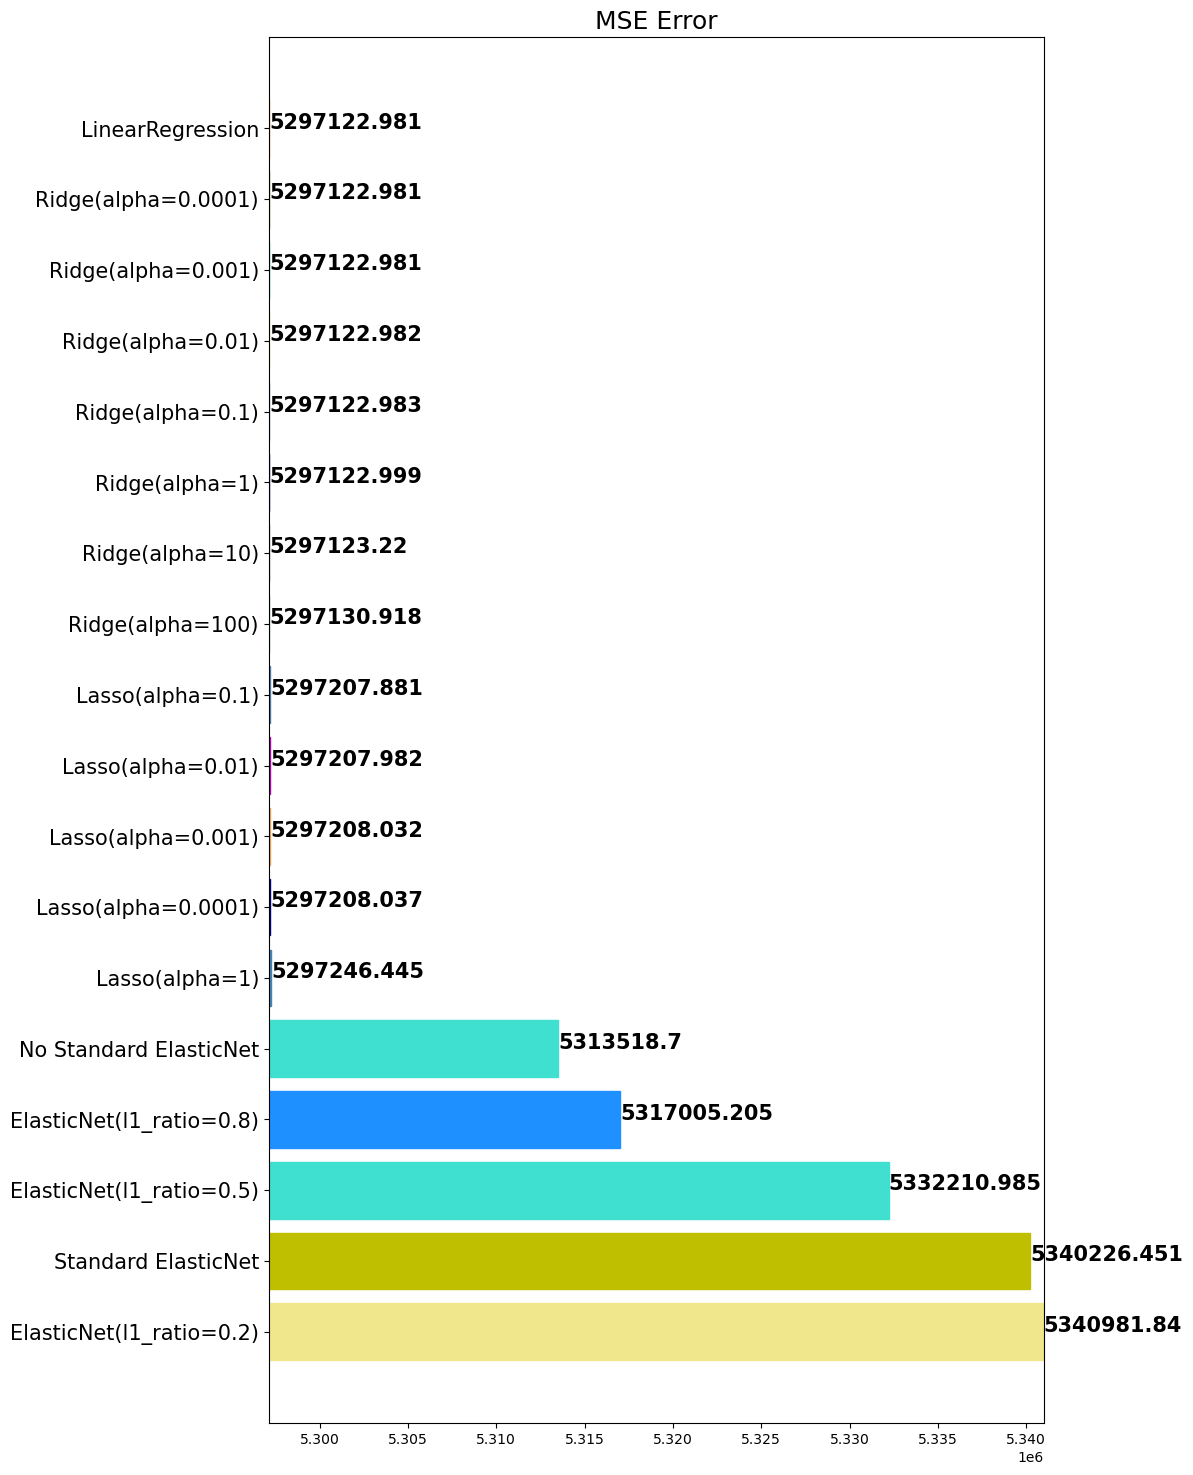

In [540]:
elasticnet_no_pipeline = ElasticNet(alpha=0.1, l1_ratio=0.2)
no_pipelline_pred = elasticnet_no_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('No Standard ElasticNet', no_pipelline_pred, y_test)

### Polynomial Features

In [541]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(x_train)[0]
## 질문 왜 [0] ##

In [542]:
poly_features

array([5.50000000e+01, 2.26000000e+01, 0.00000000e+00, 1.30000000e+00,
       9.90000000e+01, 0.00000000e+00, 0.00000000e+00, 2.02200000e+03,
       7.00000000e+00, 2.20000000e+01, 1.00000000e+00, 4.00000000e+00,
       6.00000000e+00, 2.53418700e+04, 1.30401000e+04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.02500000e+03, 1.24300000e+03,
       0.00000000e+00, 7.15000000e+01, 5.44500000e+03, 0.00000000e+00,
       0.00000000e+00, 1.11210000e+05, 3.85000000e+02, 1.21000000e+03,
       5.50000000e+01, 2.20000000e+02, 3.30000000e+02, 1.39380285e+06,
       7.17205500e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.10760000e+02, 0.00000000e+00, 2.93800000e+01, 2.23740000e+03,
       0.00000000e+00, 0.00000000e+00, 4.56972000e+04, 1.58200000e+02,
       4.97200000e+02, 2.26000000e+01, 9.04000000e+01, 1.35600000e+02,
       5.72726262e+05, 2.94706260e+05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [550]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    ElasticNet(alpha=0.1, l1_ratio=0.2)
)

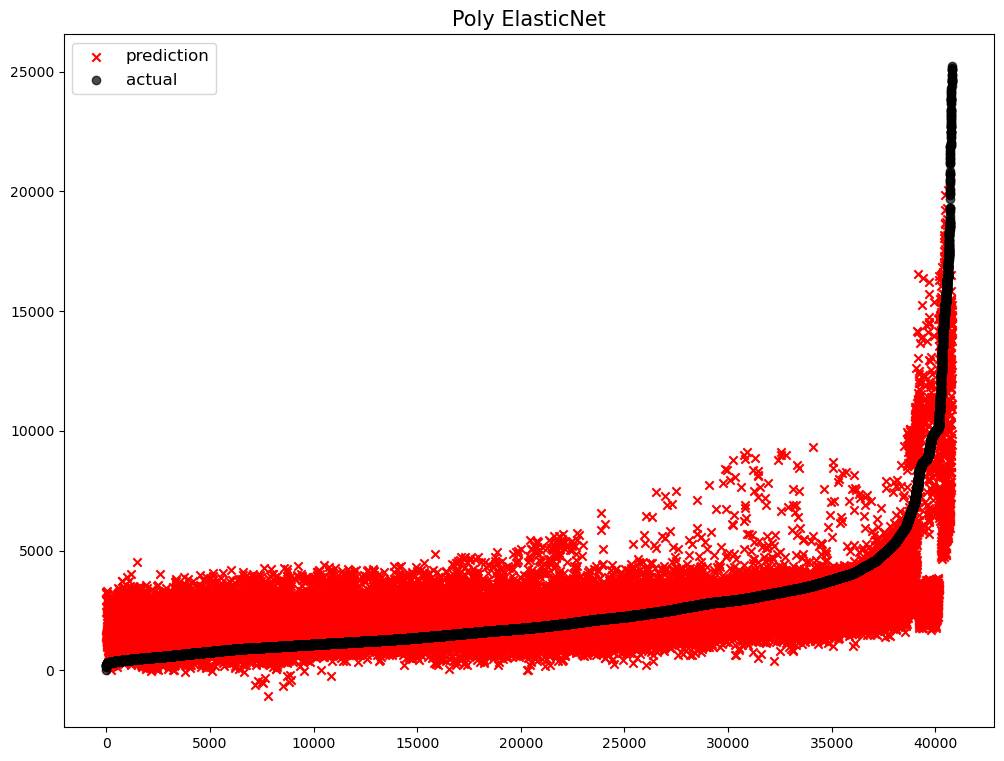

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1        Standard ElasticNet  5.340226e+06
2   ElasticNet(l1_ratio=0.5)  5.332211e+06
3   ElasticNet(l1_ratio=0.8)  5.317005e+06
4     No Standard ElasticNet  5.313519e+06
5             Lasso(alpha=1)  5.297246e+06
6        Lasso(alpha=0.0001)  5.297208e+06
7         Lasso(alpha=0.001)  5.297208e+06
8          Lasso(alpha=0.01)  5.297208e+06
9           Lasso(alpha=0.1)  5.297208e+06
10          Ridge(alpha=100)  5.297131e+06
11           Ridge(alpha=10)  5.297123e+06
12            Ridge(alpha=1)  5.297123e+06
13          Ridge(alpha=0.1)  5.297123e+06
14         Ridge(alpha=0.01)  5.297123e+06
15        Ridge(alpha=0.001)  5.297123e+06
16       Ridge(alpha=0.0001)  5.297123e+06
17          LinearRegression  5.297123e+06
18           Poly ElasticNet  3.060922e+06


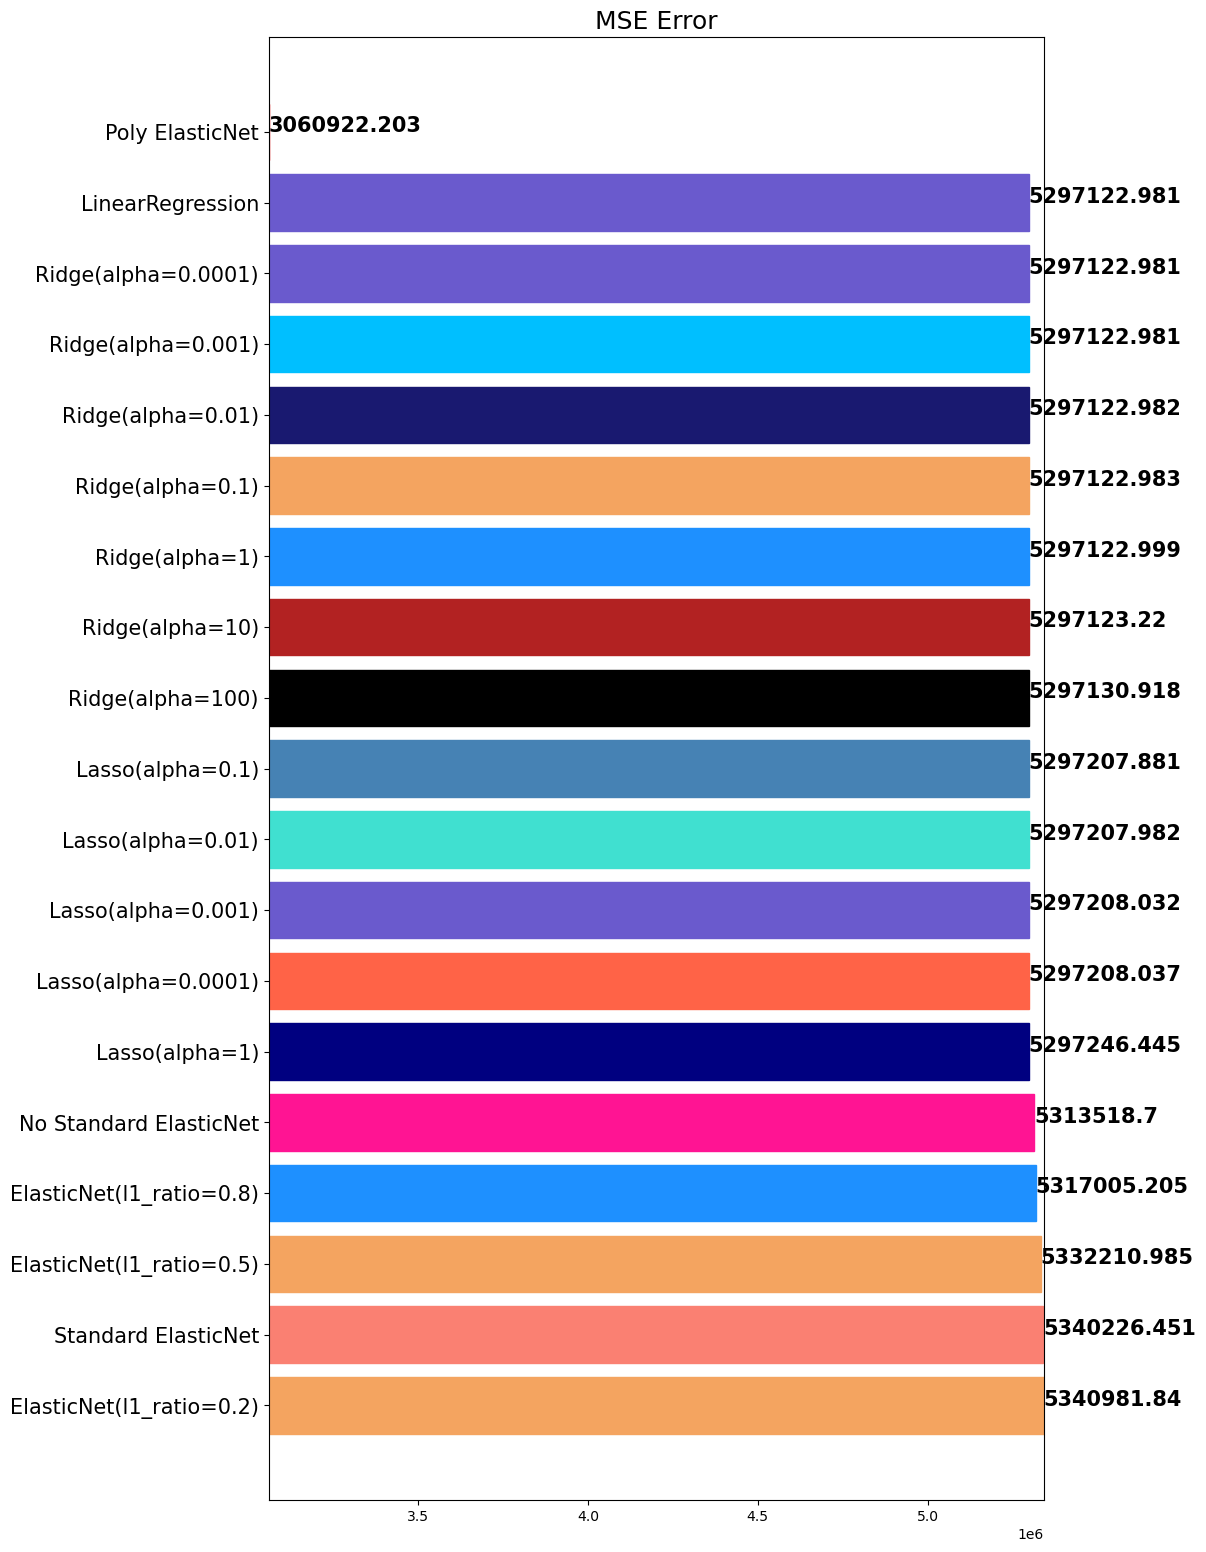

In [551]:
poly_pred = poly_pipeline.fit(x_train, y_train).predict(x_test)
mse_eval('Poly ElasticNet', poly_pred, y_test)

## 보팅(Voting)

In [553]:
single_models =[
    ('linear_reg', model),
    ('ridge', ridge),
    ('lasso', lasso),
    ('elasticnet_pipeline', elasticnet_pipeline),
    ('poly_pipeline', poly_pipeline)
]

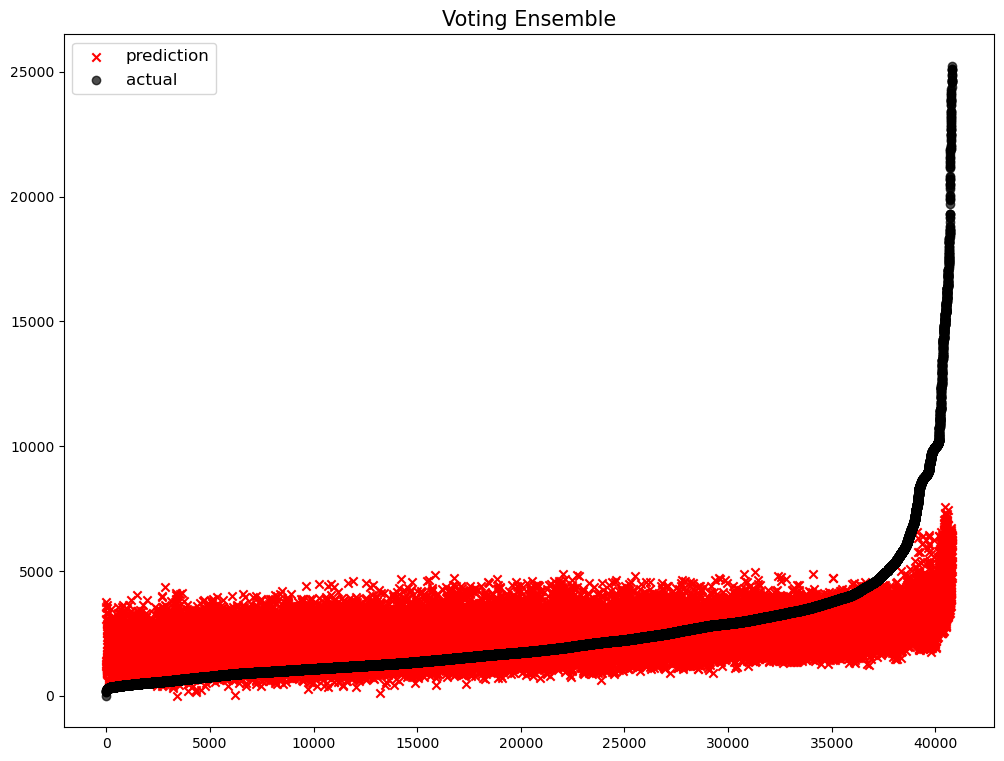

                       model           mse
0   ElasticNet(l1_ratio=0.2)  5.340982e+06
1        Standard ElasticNet  5.340226e+06
2   ElasticNet(l1_ratio=0.5)  5.332211e+06
3   ElasticNet(l1_ratio=0.8)  5.317005e+06
4     No Standard ElasticNet  5.313519e+06
5             Lasso(alpha=1)  5.297246e+06
6        Lasso(alpha=0.0001)  5.297208e+06
7         Lasso(alpha=0.001)  5.297208e+06
8          Lasso(alpha=0.01)  5.297208e+06
9           Lasso(alpha=0.1)  5.297208e+06
10          Ridge(alpha=100)  5.297131e+06
11           Ridge(alpha=10)  5.297123e+06
12            Ridge(alpha=1)  5.297123e+06
13          Ridge(alpha=0.1)  5.297123e+06
14         Ridge(alpha=0.01)  5.297123e+06
15        Ridge(alpha=0.001)  5.297123e+06
16       Ridge(alpha=0.0001)  5.297123e+06
17          LinearRegression  5.297123e+06
18           Voting Ensemble  4.547230e+06
19           Poly ElasticNet  3.060922e+06


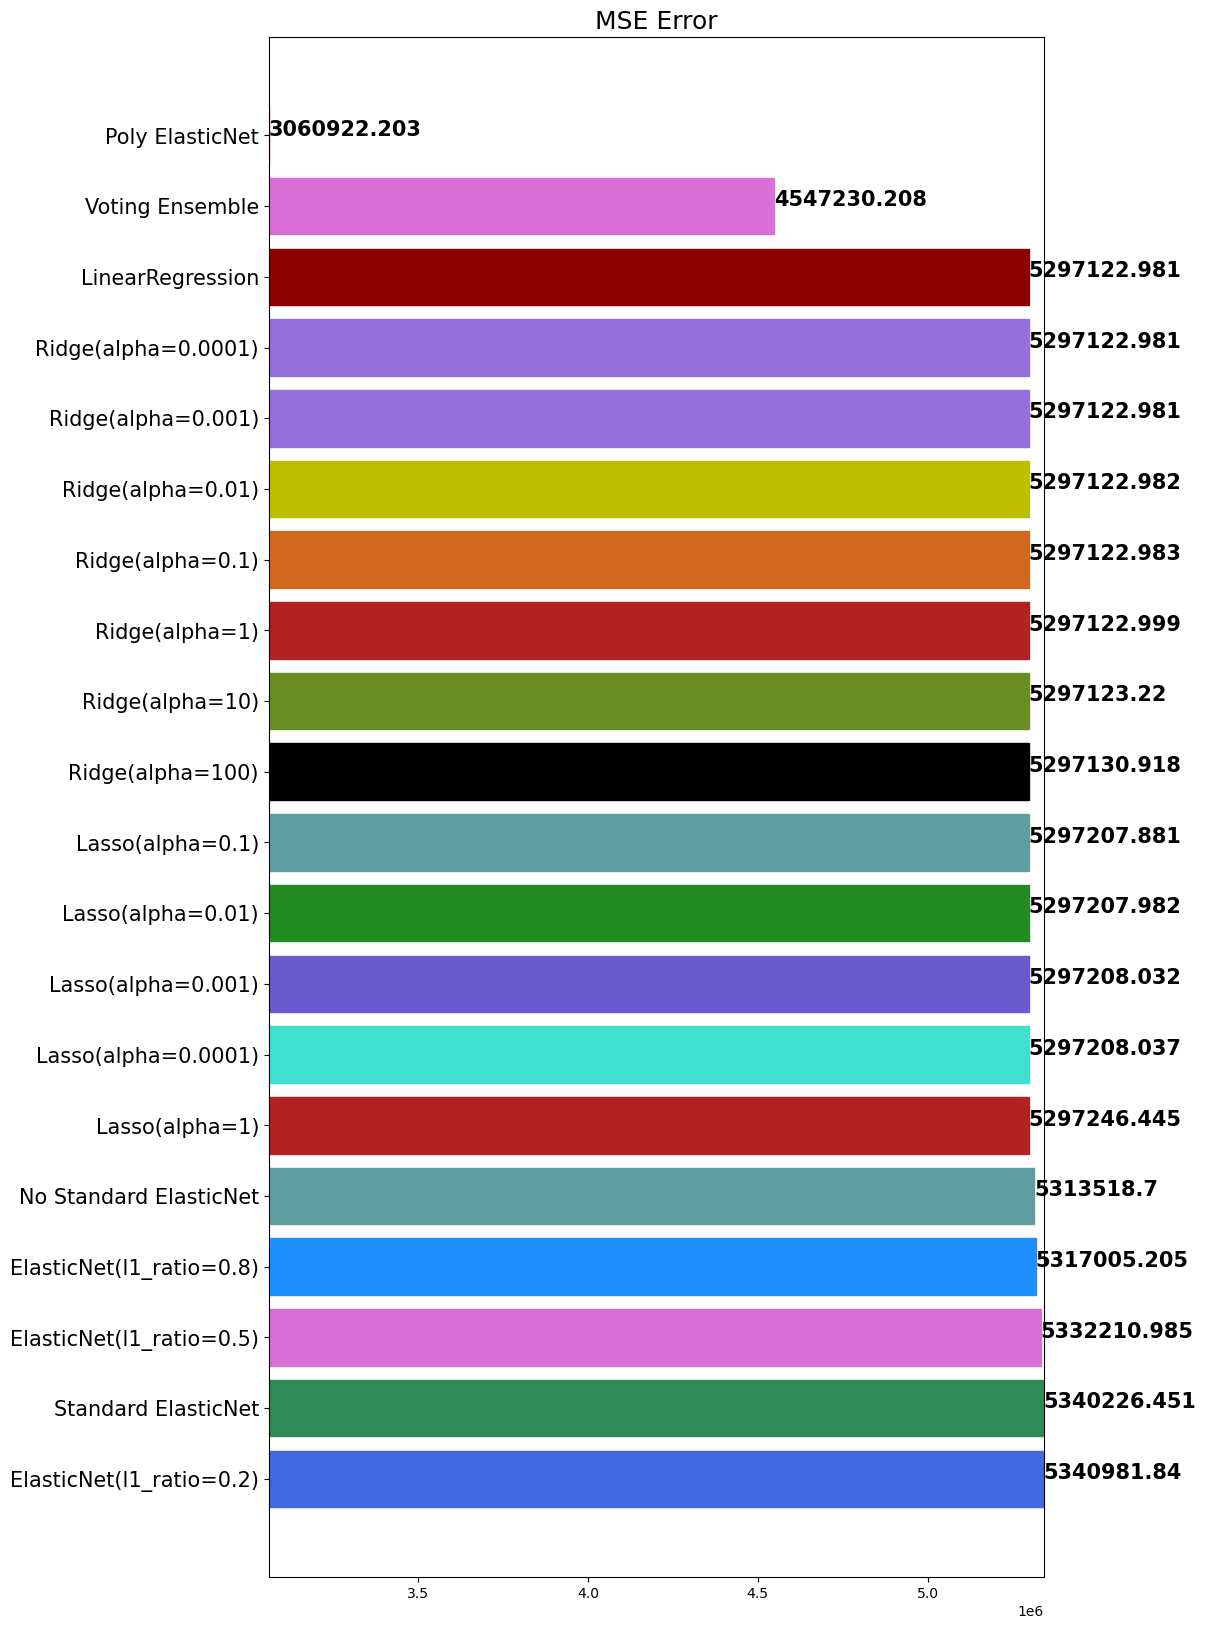

In [554]:
voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(x_train, y_train)
voting_pred = voting_regressor.predict(x_test)
mse_eval('Voting Ensemble', voting_pred, y_test)

## Regression Model Fit

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

## Test Data Pre-Processing

In [ ]:
test_df['month'] = test_df['일시'].apply(lambda x : int(x[4:6]))
test_df['day'] = test_df['일시'].apply(lambda x : int(x[6:8]))
test_df['time'] = test_df['일시'].apply(lambda x : int(x[9:11]))

In [ ]:
test_x = test_df.drop(columns=['num_date_time', '일시'])

## Inference

In [ ]:
preds = model.predict(test_x)